In [23]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from monetio.models import hysplit

In [25]:
from utilvolc import volcat
import utilvolc.ash_inverse as ai
import utilvolc.ash_eval as ae
from utilvolc import volcMER
from utilhysplit.evaluation import ensemble_tools
from utilhysplit.evaluation import plume_stat
import cases

In [43]:
%autoreload
case = cases.runM()
print(case)
tag = case.vhash['tag']
tdir = case.vhash['tdir']
tname = case.vhash['tname']
configdir= case.vhash['configdir']
configfile = case.vhash['configfile']
vdir = case.vhash['vdir']
vid = case.vhash['vid']
gdir = case.vhash['gdir']
graphicstype = case.vhash['graphicstype']
vloc = case.vhash['vloc']

vloc : [160.587, 55.978]
tag : M
tdir : ../RunM/RunM_1_2_3_4_TF
tname : RunM4.nc
configdir : ../RunM
configfile : config.invbezyM.txt
vdir : ../data/volcat/
vid : v300250
gdir : ./graphics/
graphicstype : png



In [5]:
%autoreload
aeval = ae.AshEval(tdir,tname,vdir,vid,configdir=configdir,configfile=configfile)

In [6]:
%autoreload
#time list to prepare.
# start with one hour after eruption. 21:00-22:00
dlist = []
sdate = datetime.datetime(2020,10,21,22,0)
#sdate = datetime.datetime(2020,10,22,12,0)
dt = datetime.timedelta(hours=1)
for iii in np.arange(0,20):
    drange = [sdate, sdate+dt]
    dlist.append(drange)
    sdate += dt
print(dlist[0])
print(dlist[-1])

[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 22, 17, 0), datetime.datetime(2020, 10, 22, 18, 0)]


In [22]:
'mult' in aeval.cdump.attrs

False

In [27]:
%autoreload
# For the cylindrical source change the MER.
if 'mult' in aeval.cdump.attrs:
    xmult = aeval.cdump.mult
    print('{:2e}'.format(xmult))
    # convert unit mass using the 15000 kg/s from volcat.
    from utilvolc import volcMER
    cmult = volcMER.MER2unit(1.5e4,1)
    print('Using 15000 kg/s: unit mass =  {:2e} g/hr'.format(cmult[0]))
    cmult = cmult[0] 
    # divide by the old conversion factor and multiply by the new one.
    # Note that this does not change the cdump attribute but only affects output.
    aeval.set_concmult(cmult/xmult)
else:
    aeval.set_concmult(1)

In [28]:
# time averages observations
# matches observations and model forecast to the same domain.
# these are stored in dictionaries.
%autoreload
for drange in dlist:
    print(drange)
    aeval.prepare_one_time(drange)

[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 21, 23, 0), datetime.datetime(2020, 10, 22, 0, 0)]
[datetime.datetime(2020, 10, 22, 0, 0), datetime.datetime(2020, 10, 22, 1, 0)]
[datetime.datetime(2020, 10, 22, 1, 0), datetime.datetime(2020, 10, 22, 2, 0)]
[datetime.datetime(2020, 10, 22, 2, 0), datetime.datetime(2020, 10, 22, 3, 0)]
[datetime.datetime(2020, 10, 22, 3, 0), datetime.datetime(2020, 10, 22, 4, 0)]
[datetime.datetime(2020, 10, 22, 4, 0), datetime.datetime(2020, 10, 22, 5, 0)]
[datetime.datetime(2020, 10, 22, 5, 0), datetime.datetime(2020, 10, 22, 6, 0)]
[datetime.datetime(2020, 10, 22, 6, 0), datetime.datetime(2020, 10, 22, 7, 0)]
[datetime.datetime(2020, 10, 22, 7, 0), datetime.datetime(2020, 10, 22, 8, 0)]
[datetime.datetime(2020, 10, 22, 8, 0), datetime.datetime(2020, 10, 22, 9, 0)]
[datetime.datetime(2020, 10, 22, 9, 0), datetime.datetime(2020, 10, 22, 10, 0)]
[datetime.datetime(2020, 10, 22, 10, 0), datetim

In [8]:
# time periods available.
aeval.volcat_avg_hash.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [9]:
#ht = 6.2
ht = 9.0
vent = 2.88
m63 = 0.1
dmult = volcMER.HT2unit(ht-vent,m63)
print('Height of {}km: unit mass = {:2e}'.format(ht,dmult))

HEIGHT 6.1 km,  MER 2.590e+05 kg/s , M63 0.100000 , unit mass=9.326e+10 g/hr.
Height of 9.0km: unit mass = 9.325757e+10


In [10]:
%autoreload
# this will utilize the self.concmult set earlier.
aeval.calc_massload()

# Fractions Skill Score FSS, MAE, and MSE

In [11]:
%autoreload
volcat=[]
forecast=[]
pixel_match=False
threshold=0.1
# get_pair will return the cdump multiplied by the concmult factor set earlier.
# get these times.
for tii in [4,5,6,7,8,9,10,11,12,13,14,15,16]:
    obs, model = aeval.get_pair(tii)
    forecast.append(model)
    volcat.append(obs)

# dft is a pandas dataframe
dft, dft2 = ensemble_tools.ens_time_fss(forecast,volcat,threshold=threshold,
                                  neighborhoods=[1,3,5,7,9,11,13,15,17,19,21],plot=False,
                                  pixel_match=pixel_match)
print(dft.columns)

Index(['Nlen', 'FBS', 'FBS_ref', 'FSS', 'random', 'uniform', 'afss', 'ens',
       'time'],
      dtype='object')


plotting


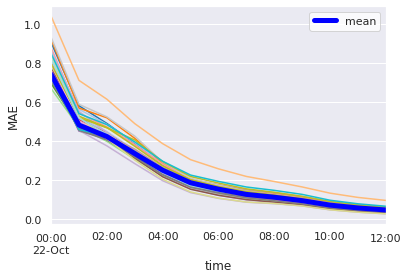

plotting


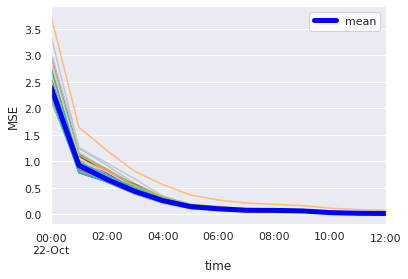

plotting


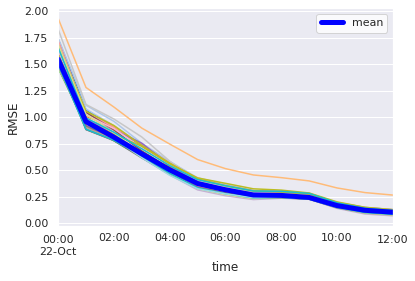

In [12]:
#  MAE, MSE, RMSE as function of time.
%autoreload
sns.set()
sns.set_style('whitegrid')
ensemble_tools.plot_ens_accuracy(dft2,'MAE')
plt.savefig(gdir + 'run{}_mae_ts_t{}.{}'.format(tag,threshold,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'MSE')
plt.savefig(gdir + 'run{}_mse_ts_t{}.{}'.format(tag,threshold,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'RMSE')
plt.savefig(gdir + 'run{}_rmse_ts_t{}.{}'.format(tag,threshold,graphicstype))

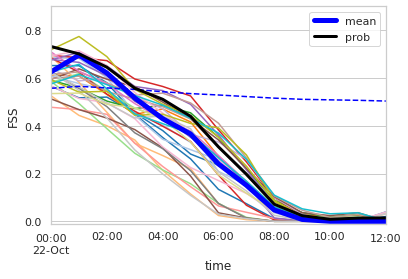

In [30]:
# FSS at one neightborhood size as a function of time.
# different colored lines are the different ensemble members.
# Uses output from the cell above.
%autoreload
sns.set()
sns.set_style('whitegrid')
# grid size is 0.1 degrees.
# neighborhood gives the number of grid squares to
# look at. 10 would be a 1degree x 1 degree area.
neighborhood = 3
ensemble_tools.plot_ens_fss_ts(dft,nval=neighborhood)
ax = plt.gca()
ax.set_ylim(-0.01,0.9)
plt.savefig(gdir + 'run{}_fss_ts_n{}_t{}.{}'.format(tag,neighborhood,threshold,graphicstype))

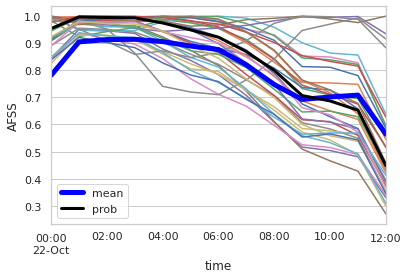

In [14]:
# plots the AFSS which is a measure of frequency bias as a function of time.
# The FSS will approach this value as neighborhood size approaches domain size.
# When pixel matching is used, this will always be 1.
%autoreload
afss = ensemble_tools.plot_afss_ts(dft)
plt.savefig(gdir + 'run{}_afss_ts_t{}.{}'.format(tag,threshold,graphicstype))

In [31]:
# Look at one time period, different neighbhorhood sizes.
%autoreload
tii=8
pixel_match=False
threshold=0.1
threshstr = str(threshold).replace('.','p')
timeval = aeval.cdump.time.values[tii]
print(timeval)
volcat,forecast = aeval.get_pair(tii)
print(aeval.concmult)
#forecast = aeval.cdump_hash[tii]
nb = np.arange(1,21,2)
nb = np.append(nb,[31,41,51])
if tii > 8:
    nb = np.append(nb,[61,71,81,91,101])
thresh=0.1
nb = [11,81,91]
# msc and psc are CalcScores objects.
# msc is for the ensemble mean (deterinistic)
# psc is for the probabilistic model field.
msc, psc, df1, dfmae = ensemble_tools.ens_fss(forecast,volcat,threshold=threshold,
                                       neighborhoods=nb,
                                       return_objects=True,plot=False,
                                       pixel_match=pixel_match)

2020-10-22T04:00:00.000000000
1


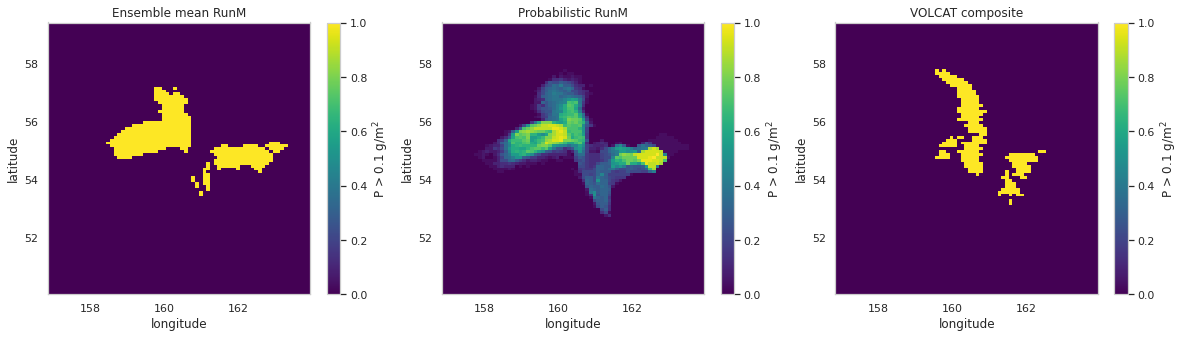

In [32]:
# Plots of 
fig = plt.figure(1,figsize=[20,5])
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
chash = {'label': 'P > {} g/m$^2$'.format(threshold)}
msc.binxra2.plot.pcolormesh(ax=ax1,x='longitude',y='latitude', cbar_kwargs=chash)
psc.binxra2.plot.pcolormesh(ax=ax2,x='longitude',y='latitude', cbar_kwargs=chash)
psc.binxra1.plot.pcolormesh(ax=ax3,x='longitude',y='latitude',cbar_kwargs=chash)
ax1.set_title('Ensemble mean Run{}'.format(tag))
ax2.set_title('Probabilistic Run{}'.format(tag))
ax3.set_title('VOLCAT composite')
timeval = pd.to_datetime(timeval)
timestr = timeval.strftime("%Y%m%dT%H")
timeval2 = timeval + datetime.timedelta(hours=1)
timestr2 = timeval2.strftime("T%H")
plt.savefig(gdir + 'binary_fields_run{}_t_{}_{}_{}'.format(tag,threshstr,timestr,timestr2))

[0.54225352]


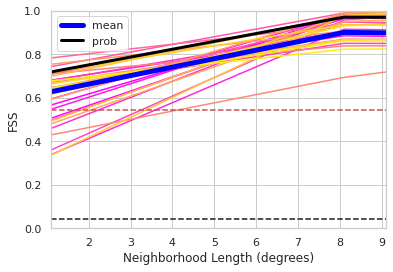

In [33]:
%autoreload
sns.set()
sns.set_style('whitegrid')
print(df1['uniform'].unique())
ensemble_tools.plot_ens_fss(df1,sizemult=0.1)
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_ylabel('FSS')
ax.set_xlabel('Neighborhood Length (degrees)')
plt.savefig(gdir + 'FSS_run{}_t{}_{}_{}'.format(tag, threshstr, timestr,timestr2))

In [34]:
df1[df1.ens=='mean']

Nlen       FBS   FBS_ref       FSS    random   uniform      afss   ens  \
11    11  0.017296  0.046516  0.628182  0.042254  0.542254  0.906006  mean   
81    81  0.000417  0.004202  0.900844  0.042254  0.542254  0.906006  mean   
91    91  0.000319  0.003141  0.898439  0.042254  0.542254  0.906006  mean   

                  time  length (degrees)  
11 2020-10-22 04:00:00               1.1  
81 2020-10-22 04:00:00               8.1  
91 2020-10-22 04:00:00               9.1

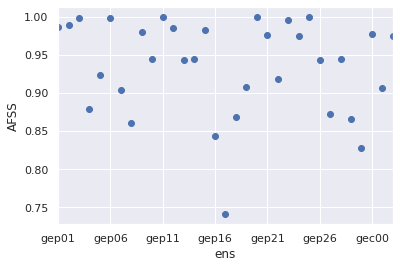

In [35]:
sns.set()
ensemble_tools.plot_afss(df1)

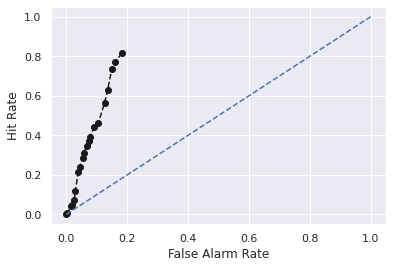

In [36]:
# Calculate ROC curve using 
xlist, ylist = psc.calc_roc(clip=True)
plume_stat.plot_roc(xlist,ylist)
threshstr = str(threshold).replace('.','p')
plt.savefig(gdir + 'ROC_run{}_t{}_{}_{}'.format(tag,threshstr, timestr,timestr2))

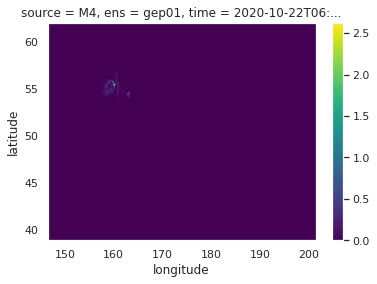

In [37]:
aeval.massload.sel(ens='gep01').isel(time=10).plot.pcolormesh(x='longitude',y='latitude')

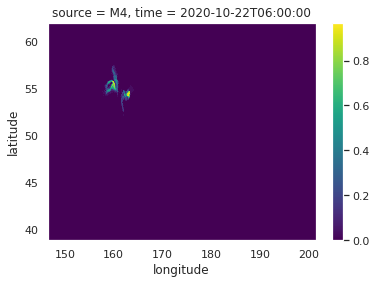

In [38]:
%autoreload
sns.set()
temp = aeval.massload
atl = ensemble_tools.ATL(temp,thresh=0.2)
atl.isel(time=10).plot.pcolormesh(x='longitude',y='latitude')

In [39]:
dim = 'ens'
temp[dim].values

array(['gep01', 'gep02', 'gep03', 'gep04', 'gep05', 'gep06', 'gep07',
       'gep08', 'gep09', 'gep10', 'gep11', 'gep12', 'gep13', 'gep14',
       'gep15', 'gep16', 'gep17', 'gep18', 'gep19', 'gep20', 'gep21',
       'gep22', 'gep23', 'gep24', 'gep25', 'gep26', 'gep27', 'gep28',
       'gep29', 'gep30', 'gec00'], dtype=object)

2020-10-22T04:00:00.000000000
tii 8


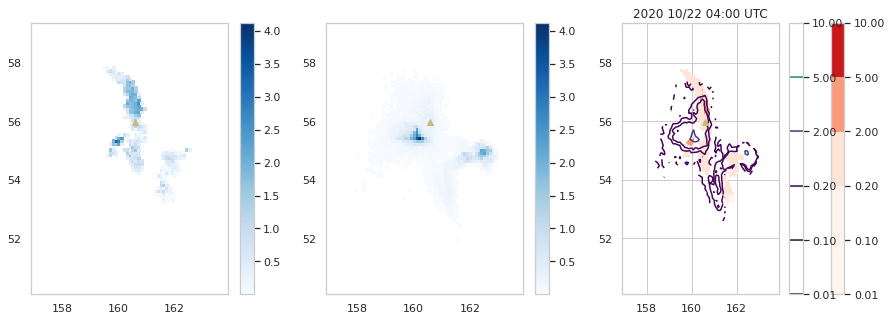

tii 8


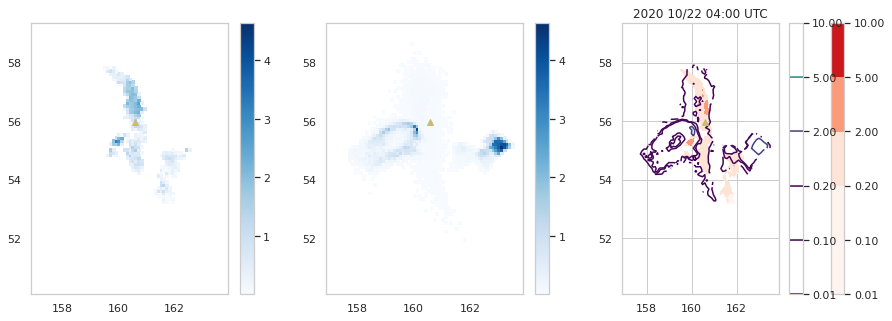

tii 8


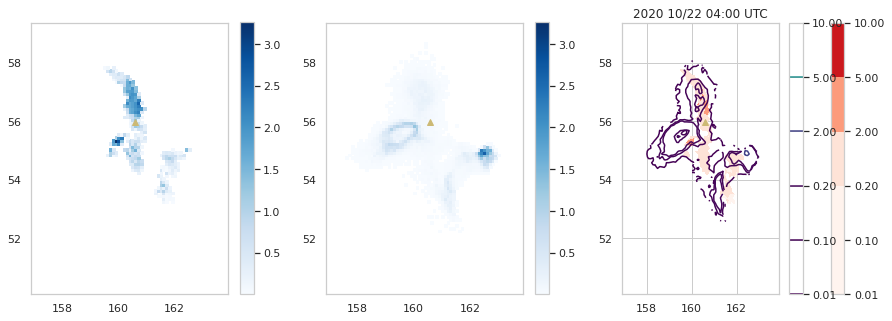

tii 8


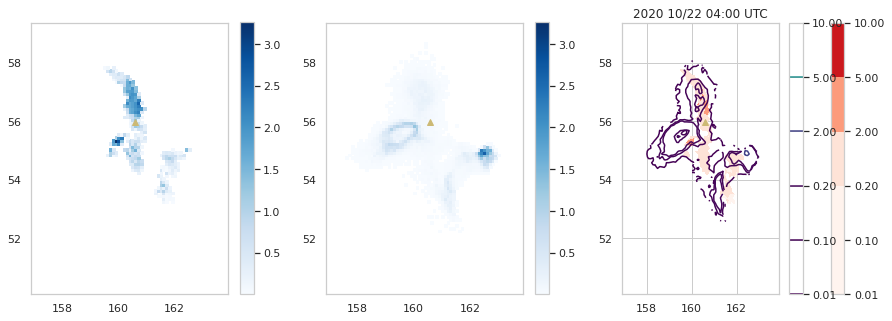

tii 8


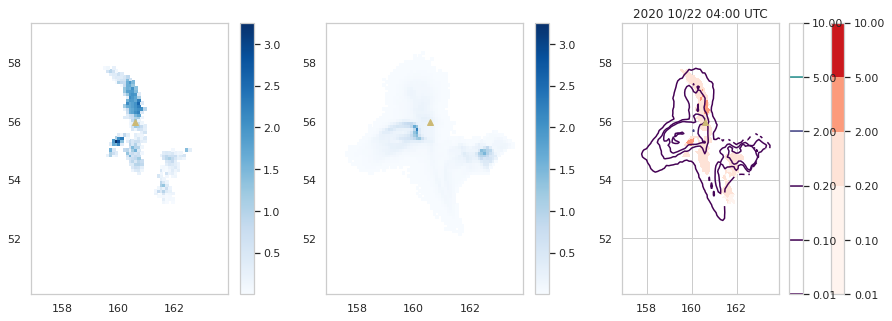

tii 8


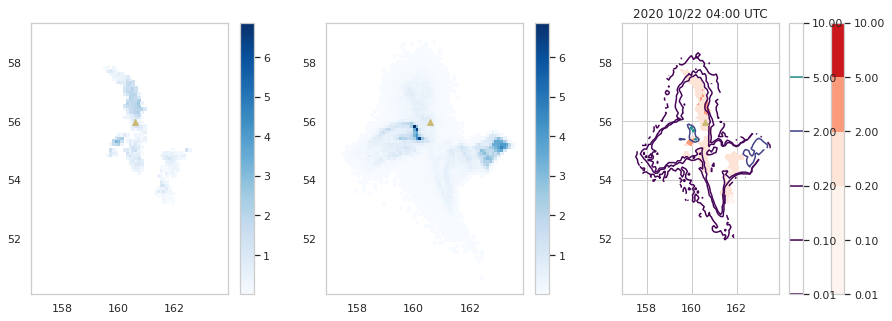

In [47]:
%autoreload
tii = 8  # time period
print(aeval.massload.time.values[tii])
# Comparison of some of the different ensemble members
fig = aeval.compare_forecast(aeval.massload.sel(ens='gep26').isel(time=tii),vloc=vloc)
plt.show()
fig = aeval.compare_forecast(aeval.massload.sel(ens='gep05').isel(time=tii),vloc=vloc)
plt.show()
fig = aeval.compare_forecast(aeval.massload.sel(ens='gep10').isel(time=tii),vloc=vloc)
plt.show()
fig = aeval.compare_forecast(aeval.massload.sel(ens='gep10').isel(time=tii),vloc=vloc)
plt.show()
# mean of ensemble
fig = aeval.compare_forecast(aeval.massload.mean(dim='ens').isel(time=tii),vloc=vloc)
plt.show()
# maximum of ensemble
fig = aeval.compare_forecast(aeval.massload.max(dim='ens').isel(time=tii),vloc=vloc)

# Comparing CDF

['2020-10-21T20:00:00.000000000' '2020-10-21T21:00:00.000000000'
 '2020-10-21T22:00:00.000000000' '2020-10-21T23:00:00.000000000'
 '2020-10-22T00:00:00.000000000' '2020-10-22T01:00:00.000000000'
 '2020-10-22T02:00:00.000000000' '2020-10-22T03:00:00.000000000'
 '2020-10-22T04:00:00.000000000' '2020-10-22T05:00:00.000000000'
 '2020-10-22T06:00:00.000000000' '2020-10-22T07:00:00.000000000'
 '2020-10-22T08:00:00.000000000' '2020-10-22T09:00:00.000000000'
 '2020-10-22T10:00:00.000000000' '2020-10-22T11:00:00.000000000'
 '2020-10-22T12:00:00.000000000' '2020-10-22T13:00:00.000000000'
 '2020-10-22T14:00:00.000000000' '2020-10-22T15:00:00.000000000'
 '2020-10-22T16:00:00.000000000' '2020-10-22T17:00:00.000000000'
 '2020-10-22T18:00:00.000000000' '2020-10-22T19:00:00.000000000']


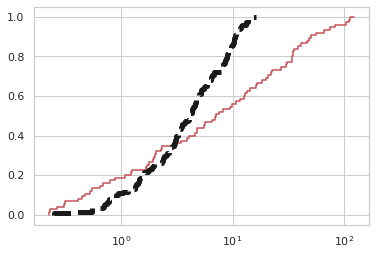

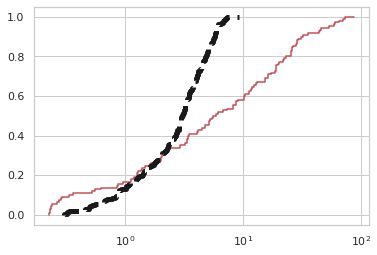

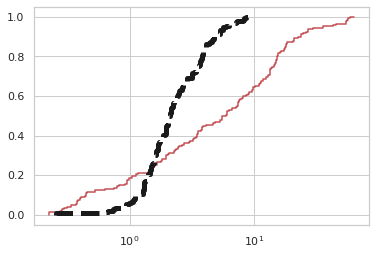

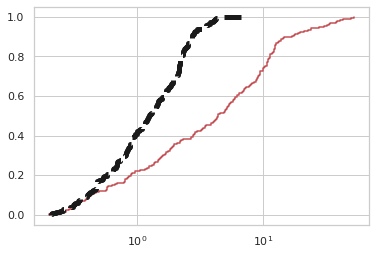

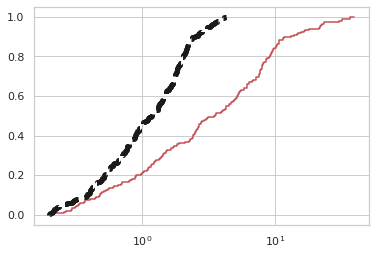

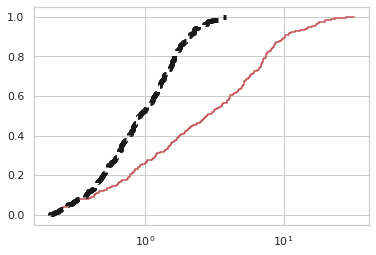

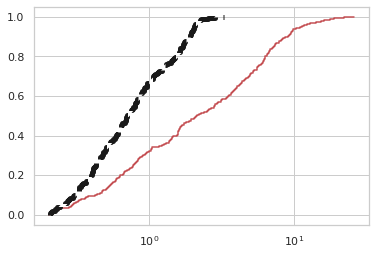

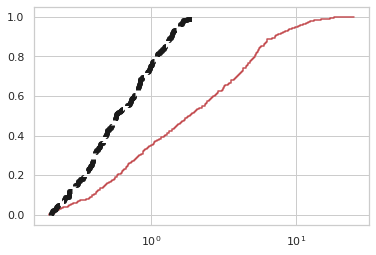

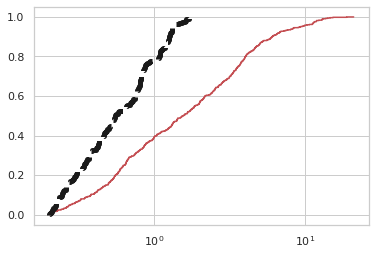

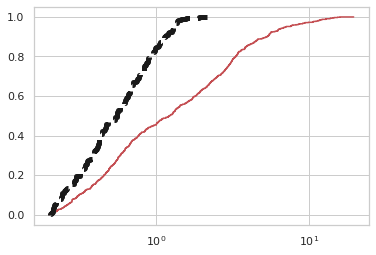

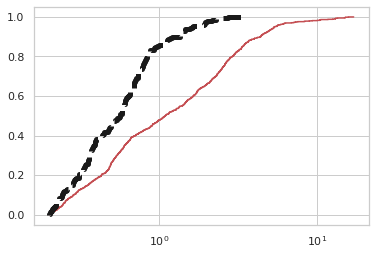

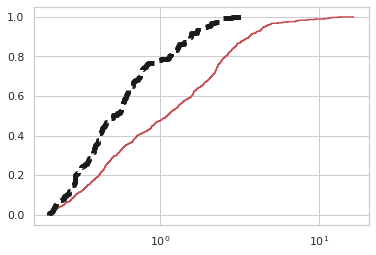

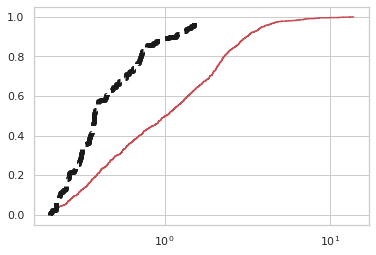

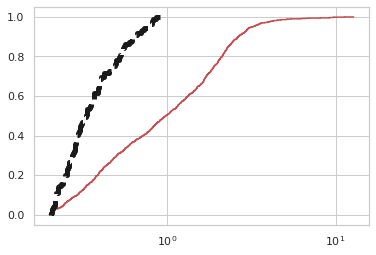

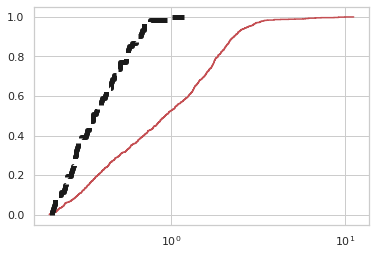

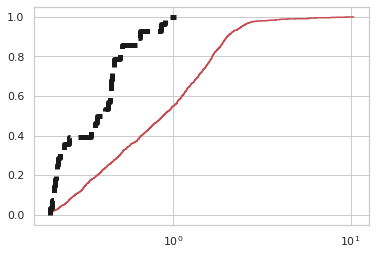

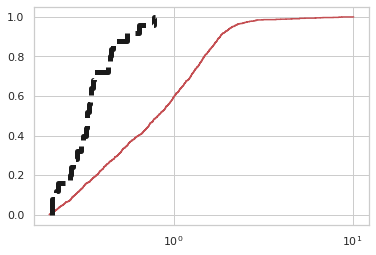

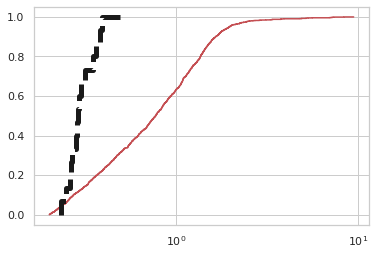

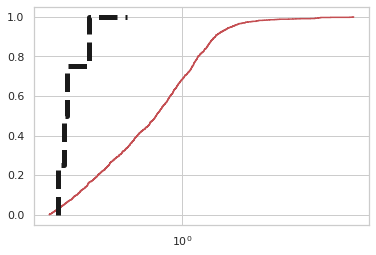

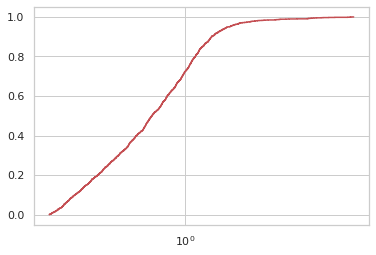

<Figure size 432x288 with 0 Axes>

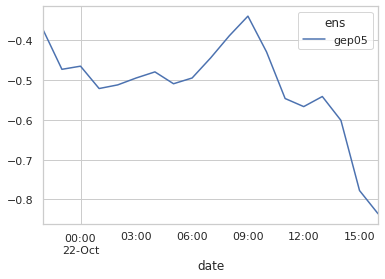

In [60]:
%autoreload
# one ensemble member at all times.
tii=5
timelist = aeval.massload.time.values
enslist = aeval.massload.ens.values
enslist = [enslist[tii]]
#timelist = [aeval.massload.time.values[tii]]
print(timelist)
#print(enslist)
threshold = 0.2
# CDF with pixel matching. Threshold will be different for every ensemble member as well as fo
# volcat data. First threshold is applied to VOLCAT data. Number of VOLCAT pixels above threshold
# is counted.
use_pixel_match=False
aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
ax = plt.gca()
#add_lines(ax)
plt.show()
#use_pixel_match=False
#kslist = aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
#ax = plt.gca()
#add_lines(ax)

[numpy.datetime64('2020-10-22T04:00:00.000000000')]


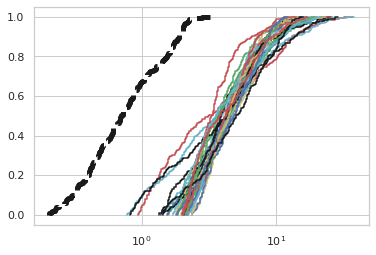

<Figure size 432x288 with 0 Axes>

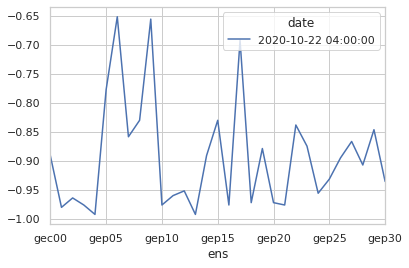

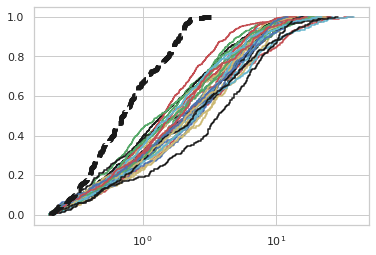

<Figure size 432x288 with 0 Axes>

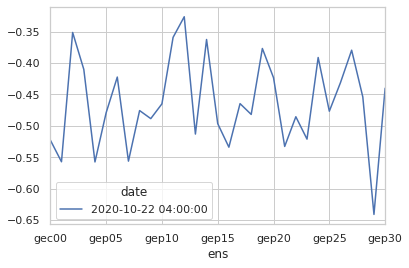

In [62]:
%autoreload
# CDF for all ensemble members at one time.
tii=8  # choose time index
timelist = aeval.massload.time.values
enslist = aeval.massload.ens.values
enslist = None
timelist = [aeval.massload.time.values[tii]]
print(timelist)
#print(enslist)
threshold = 0.2
# CDF with pixel matching. Threshold will be different for every ensemble member as well as fo
# volcat data. First threshold is applied to VOLCAT data. Number of VOLCAT pixels above threshold
# is counted.
use_pixel_match=True
aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
ax = plt.gca()
#add_lines(ax)
plt.show()
# CDF with no pixel matching. Thresholds are the same for every ensemble member and volcat data.
# number of above threshold pixels will be different.
use_pixel_match=False
kslist = aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
ax = plt.gca()
#add_lines(ax)


# ROC diagrams

In [48]:
%autoreload
tii = 8
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]
probscores = plume_stat.CalcScores(volcat, forecast,threshold=0.1,probabilistic=True)


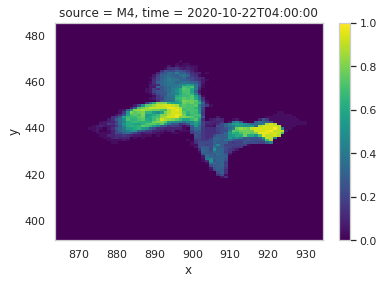

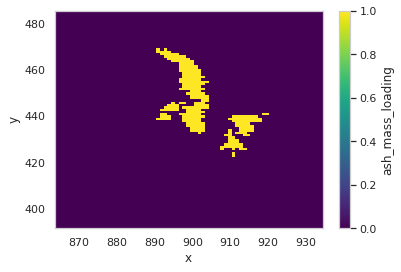

In [49]:
probscores.binxra2.plot.pcolormesh()
plt.show()
probscores.binxra1.plot.pcolormesh()

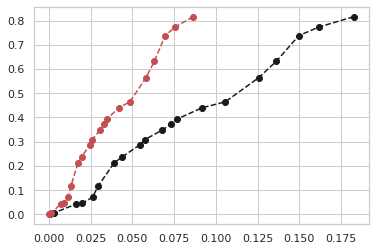

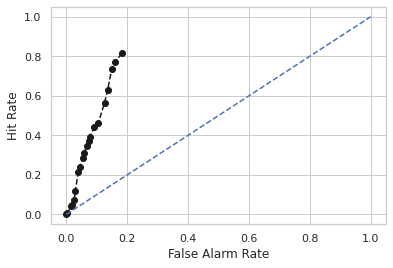

In [50]:
%autoreload
sns.set()
sns.set_style('whitegrid')
pm=True
datedf1 = pd.to_datetime(aeval.cdump.time.values[tii])
timetag = datedf1.strftime("%Y%m%dT%H")
if pm: timetag + '_pm'

xlist, ylist = probscores.calc_roc(clip=True)
xlist2,ylist2 = probscores.calc_roc(clip=False)
plt.plot(xlist,ylist,'--ko')
plt.plot(xlist2,ylist2,'--ro')
plt.show()
plume_stat.plot_roc(xlist,ylist)
plt.savefig(gdir + 'ROC_run{}_{}'.format(tag,timetag))
#plume_stat.plot_roc(xlist2,ylist2)

# Reliability Curves

In [51]:
from utilhysplit.evaluation import reliability


In [52]:
tii = 8
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]

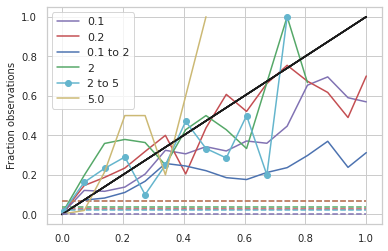

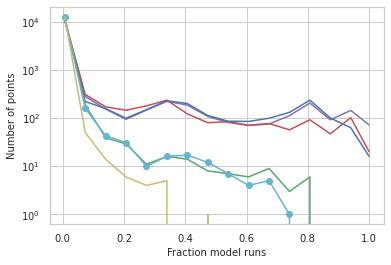

In [54]:
%autoreload
num=15  #number of bins to use on x axis.
# 
threshlist = [0.1,0.2,[0.1,2],2,[2,5],5.0]
clrs = ['-m','-r','-b','-g','-co','-y']
rclist = []
labels = []
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(1,1,1)
for thresh in threshlist:
    if isinstance(thresh,(float,int)):
        labels.append(str(thresh))
    else:
        labels.append('{} to {}'.format(thresh[0],thresh[1]))
    rclist.append(reliability.ReliabilityCurve(thresh,num))
# time periods to include in reliability diagram.
for tii in [3,4,5,6]:
#for tii in [7,8,9,10]:
    volcat = aeval.volcat_avg_hash[tii]
    forecast = aeval.cdump_hash[tii]
    for jjj, rc in enumerate(rclist):
        dfin = rc.reliability_add_xra(volcat,forecast,fill=True)

for jjj, rc in enumerate(rclist):
    reliability.sub_reliability_plot(rc,ax,clr=clrs[jjj],fs=10,label=labels[jjj])
    reliability.sub_reliability_number_plot(rc,ax2,clr=clrs[jjj],fs=10,label=labels[jjj])
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,labels,loc='upper left')

5.0


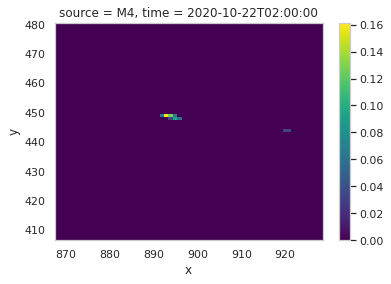

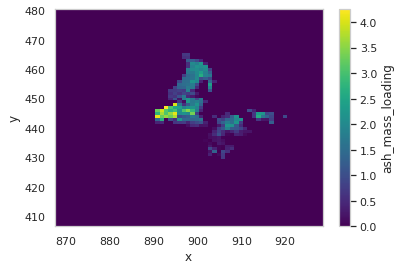

In [59]:
print(thresh)
prob = ensemble_tools.ATL(forecast,thresh=thresh,norm=True)
prob.plot.pcolormesh()
plt.show()
volcat.plot.pcolormesh()

ROW ens
obs      0.000000
gep26    0.000000
gep24    0.000000
gep19    0.000000
gep04    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep12    0.000039
gep18    0.000309
gep30    0.000329
gec00    0.000781
gep07    0.000992
gep09    0.002250
gep23    0.002893
gep29    0.003158
gep16    0.003179
gep08    0.003664
gep20    0.004616
gep17    0.005871
gep06    0.006093
gep22    0.006219
gep15    0.006227
gep28    0.008730
gep02    0.010692
gep14    0.011502
gep25    0.020243
gep27    0.027061
gep03    0.030351
gep21    0.034671
gep01    0.062099
gep05    0.145643
Name: 876_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep13    0.000000
gep11    0.000000
gep18    0.000000
gep24    0.000000
gep19    0.000000
gep26    0.000000
gep04    0.000000
gep30    0.000331
gep28    0.000898
gep07    0.001032
gep29    0.001055
gep16    0.001938
gep20    0.002007
gep17    0.002946
gep23    0.003881
gep12    0.003931
gep06    0.004098
gep09    0.004519
gep10    0.004756
gec00  

Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000009
gep13    0.000089
gep04    0.000305
gep24    0.001012
gep11    0.002787
gep18    0.007377
gep07    0.012733
gep12    0.013145
gep26    0.013335
gep30    0.014809
gep16    0.019263
gep17    0.030811
gep15    0.031153
gep06    0.033458
gep27    0.041852
gep10    0.042520
gep28    0.042880
gep14    0.044273
gep09    0.049411
gep23    0.051981
gep08    0.056999
gep29    0.060366
gep20    0.085363
gep22    0.090023
gep25    0.095775
gec00    0.105937
gep02    0.115993
gep01    0.125277
gep03    0.128878
gep21    0.234470
gep05    0.517662
Name: 881_441, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000055
gep24    0.000370
gep13    0.000374
gep04    0.000822
gep11    0.001485
gep26    0.003514
gep18    0.015316
gep12    0.016465
gep16    0.018289
gep07    0.018711
gep30    0.018911
gep28    0.041422
gep15    0.041881
gep23    0.042928
gep02    0.050669
gep27    0.051207
gep08    0.053473
gep06    0.055684
gep20    0.061

Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.001365
gep11    0.004511
gep13    0.014124
gep19    0.015484
gep04    0.018687
gep26    0.019839
gep27    0.030967
gep17    0.036776
gep18    0.071217
gep15    0.102814
gep07    0.105037
gep30    0.110122
gep12    0.116997
gep14    0.118501
gep16    0.127085
gep28    0.149498
gep02    0.163670
gep10    0.187278
gep06    0.218379
gep23    0.223782
gep08    0.230510
gep01    0.255859
gep29    0.265077
gep20    0.296951
gep03    0.298228
gep09    0.338632
gep25    0.338872
gep21    0.352746
gec00    0.421191
gep05    0.464475
gep22    0.467968
Name: 884_443, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.002677
gep11    0.004962
gep13    0.016962
gep04    0.021736
gep19    0.031579
gep26    0.035794
gep17    0.040927
gep07    0.071002
gep30    0.078497
gep18    0.078802
gep27    0.079999
gep15    0.116300
gep02    0.133022
gep12    0.138989
gep20    0.139214
gep14    0.141880
gep16    0.148752
gep10    0.178342
gep23    0.185

Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.005155
gep11    0.006452
gep24    0.010784
gep17    0.017508
gep13    0.034537
gep19    0.037681
gep14    0.039416
gep26    0.055082
gep15    0.055490
gep18    0.086969
gep03    0.088331
gep21    0.093663
gep05    0.098868
gep04    0.104102
gep01    0.192121
gep06    0.194360
gep08    0.232738
gep23    0.238665
gep07    0.256681
gep09    0.280231
gep29    0.281028
gep30    0.321442
gep25    0.327532
gep20    0.371333
gep22    0.419550
gep02    0.419560
gep16    0.452559
gep12    0.486789
gec00    0.540982
gep28    0.570951
gep10    0.689548
Name: 887_443, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.000000
gep11    0.004624
gep14    0.009968
gep17    0.011187
gep24    0.016999
gep19    0.046379
gep05    0.052842
gep13    0.055321
gep26    0.074264
gep15    0.075166
gep21    0.110586
gep03    0.118854
gep04    0.121402
gep01    0.149500
gep18    0.162084
gep06    0.196447
gep23    0.260079
gep09    0.269340
gep22    0.330

ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep27    0.000000
gep23    0.000000
gep14    0.000000
gep03    0.000005
gep20    0.000410
gep25    0.000864
gep22    0.001078
gep15    0.001819
gep05    0.001891
gep11    0.002467
gep12    0.003902
gep09    0.004515
gep21    0.010033
gec00    0.010959
gep28    0.013544
gep10    0.013779
gep17    0.016196
gep13    0.019892
gep06    0.026075
gep19    0.029820
gep18    0.036903
gep24    0.044887
gep16    0.060565
gep26    0.061406
gep30    0.081310
gep29    0.084753
gep07    0.104331
gep08    0.123772
gep04    0.197414
Name: 888_461, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep19    0.000000
gep11    0.000000
gep13    0.000000
gep02    0.000224
gep12    0.000293
gep16    0.000516
gep30    0.000884
gep28    0.001282
gep18    0.001524
gep29    0.001896
gep22    0.001930
gep07    0.003223
gec00    0.003456
gep06    0.006015
gep03    0.006058
gep14    0.006452
gep08  

Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.007296
gep17    0.024471
gep14    0.026013
gep15    0.027381
gep12    0.030697
gep01    0.056668
gep23    0.060696
gep13    0.064800
gep25    0.067718
gep02    0.069286
gep10    0.075592
gep21    0.077646
gep09    0.080989
gep20    0.088195
gep03    0.092464
gep11    0.092748
gep06    0.093459
gep07    0.096761
gep16    0.097231
gec00    0.111350
gep26    0.127579
gep19    0.130524
gep24    0.141326
gep22    0.141909
gep05    0.147820
gep29    0.156634
gep04    0.182626
gep30    0.196124
gep28    0.206796
gep18    0.292486
gep08    0.297301
Name: 890_451, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep03    0.001337
gep01    0.003691
gep27    0.004114
gep12    0.004411
gep14    0.005114
gep09    0.005695
gep20    0.006518
gep25    0.007744
gep02    0.008500
gep05    0.011383
gep15    0.012808
gep22    0.014205
gep23    0.019609
gep17    0.021014
gep21    0.025764
gec00    0.036849
gep29    0.040971
gep10    0.042205
gep11    0.063

Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000021
gep20    0.000616
gep02    0.001220
gep27    0.002599
gep25    0.003577
gep11    0.003705
gep01    0.004969
gep12    0.012119
gep09    0.013198
gep15    0.016466
gep23    0.020294
gep22    0.021111
gep21    0.021211
gep26    0.021580
gep05    0.031879
gep13    0.032986
gep17    0.048420
gec00    0.051424
gep06    0.059645
gep24    0.097212
gep10    0.107913
gep19    0.189032
gep18    0.190235
gep28    0.222333
gep08    0.268940
gep29    0.284634
gep30    0.313772
gep16    0.326710
gep04    0.356697
gep07    0.379999
Name: 891_462, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000005
gep27    0.000103
gep20    0.000678
gep02    0.001230
gep21    0.001500
gep11    0.004940
gep25    0.005532
gep15    0.007593
gep12    0.008235
gep01    0.009902
gep22    0.014956
gep23    0.015133
gep06    0.015197
gep09    0.017617
gep26    0.021635
gep05    0.023547
gec00    0.035521
gep13    0.037

Rank 28 1.341077446937561
ROW ens
obs      0.000000
gep17    0.029774
gep09    0.045110
gep27    0.053208
gep15    0.056424
gep20    0.067192
gep14    0.100666
gep22    0.123560
gep12    0.207239
gep10    0.267339
gep06    0.275952
gep01    0.348465
gep05    0.352767
gep23    0.401977
gep25    0.419603
gep02    0.459808
gep19    0.463605
gep21    0.473515
gep13    0.498066
gep29    0.542841
gec00    0.569035
gep03    0.578114
gep11    0.658334
gep08    0.744010
gep16    0.758094
gep07    0.806541
gep30    0.897736
gep28    1.033937
gep24    1.057370
gep04    1.149462
gep26    1.326854
gep18    1.642333
Name: 893_447, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep09    0.059400
gep27    0.068170
gep17    0.069086
gep20    0.095874
gep15    0.122460
gep14    0.129603
gep10    0.144963
gep23    0.175410
gep22    0.188391
gep06    0.218294
gep12    0.218358
gep13    0.222888
gep16    0.330598
gep11    0.336179
gep07    0.353286
gep24    0.406813
gep29    0.445652
gep19    0.484496

Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.003887
gep03    0.005270
gep14    0.007288
gep21    0.008114
gep20    0.011172
gep25    0.012944
gep06    0.022375
gep27    0.028422
gep26    0.029213
gep22    0.036059
gep01    0.043841
gep12    0.056902
gep15    0.058455
gep23    0.060568
gep09    0.060759
gep02    0.070596
gep17    0.083708
gep05    0.083919
gec00    0.094600
gep13    0.179376
gep10    0.179762
gep28    0.189132
gep08    0.191395
gep24    0.196752
gep29    0.253449
gep16    0.328945
gep18    0.337635
gep04    0.346982
gep07    0.415253
gep30    0.480863
gep19    0.604709
Name: 894_460, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep03    0.002615
gep14    0.003861
gep11    0.004833
gep20    0.012703
gep25    0.012843
gep27    0.019983
gep01    0.021204
gep26    0.023598
gep06    0.023969
gep21    0.025021
gep12    0.037253
gep15    0.042148
gep02    0.053403
gep09    0.064985
gep22    0.070035
gep05    0.076860
gec00    0.078150
gep23    0.081457
gep17    0.086

Rank 31 0.7352544665336609
ROW ens
obs      0.000000
gep24    0.000000
gep11    0.004116
gep12    0.004926
gep06    0.004926
gep19    0.005622
gep20    0.006082
gec00    0.006322
gep25    0.006342
gep14    0.006385
gep02    0.007098
gep28    0.007699
gep29    0.009199
gep23    0.009753
gep09    0.011489
gep07    0.013459
gep04    0.016746
gep17    0.019497
gep27    0.020142
gep15    0.021953
gep13    0.022554
gep18    0.022676
gep03    0.026086
gep26    0.028329
gep22    0.029869
gep10    0.031041
gep01    0.035296
gep21    0.035770
gep16    0.035779
gep30    0.050711
gep08    0.059906
gep05    0.210397
Name: 896_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.001665
gep12    0.002797
gep02    0.004226
gep07    0.007555
gep04    0.007964
gep11    0.008452
gep18    0.009064
gep13    0.009434
gep09    0.010149
gep20    0.010255
gep14    0.012019
gep24    0.013085
gep03    0.013089
gep06    0.016234
gep27    0.017842
gep08    0.018814
gep23    0.020083
gec00    0.02009

ROW ens
gep23    0.029484
gep09    0.036013
gep06    0.043803
gep12    0.059604
gep25    0.074154
gep17    0.076142
gep05    0.078840
gec00    0.083299
gep21    0.128056
gep10    0.133895
gep01    0.137504
gep14    0.138962
gep15    0.186439
gep16    0.196689
gep28    0.205481
gep22    0.213198
gep20    0.224156
gep03    0.225269
gep08    0.285020
gep11    0.298337
gep02    0.327043
gep26    0.344772
gep04    0.368504
gep24    0.405890
gep13    0.442943
obs      0.446821
gep27    0.456591
gep29    0.527249
gep30    0.553524
gep18    0.564253
gep07    0.657585
gep19    0.811261
Name: 897_451, dtype: float64
Rank 25 0.4468213617801666
ROW ens
gep23    0.023703
gep09    0.043116
gep12    0.064538
gep06    0.075121
gep17    0.085606
gep25    0.087598
gep05    0.089129
gep10    0.099852
gep21    0.131020
gep01    0.139847
gep03    0.141975
gec00    0.144434
gep14    0.169940
gep28    0.208429
gep15    0.218728
gep20    0.235529
gep22    0.251788
gep30    0.294031
gep16    0.315881
gep26    

ROW ens
gep03    0.008914
gep11    0.009163
gep06    0.014617
gep14    0.017469
gep21    0.030287
gep25    0.031595
gep27    0.034922
gep20    0.037196
gep15    0.066074
gep29    0.073499
gep01    0.073889
gep17    0.081596
gep26    0.082030
gep24    0.087338
gec00    0.088402
gep09    0.091514
gep02    0.094647
gep22    0.105278
gep07    0.108877
gep05    0.116445
gep08    0.118121
gep23    0.118893
gep04    0.119933
gep12    0.135630
gep18    0.168450
gep28    0.182134
gep13    0.220357
gep10    0.287974
gep19    0.441590
gep16    0.493851
gep30    0.549520
obs      1.603177
Name: 898_461, dtype: float64
Rank 31 1.6031774282455444
ROW ens
gep11    0.004495
gep14    0.007951
gep06    0.014182
gep25    0.020317
gep20    0.020902
gep03    0.021438
gep27    0.022156
gep21    0.028078
gep26    0.032874
gep01    0.040639
gep24    0.054725
gep04    0.061264
gep15    0.065009
gep09    0.075520
gep29    0.078336
gep08    0.079522
gep02    0.082221
gec00    0.090657
gep05    0.094110
gep22    

ROW ens
obs      0.000000
gep28    0.000000
gep25    0.000895
gep12    0.002025
gep01    0.008238
gep05    0.014138
gep21    0.014571
gep20    0.014803
gep14    0.016477
gep11    0.016607
gep06    0.020884
gep09    0.021554
gep27    0.024435
gep02    0.026397
gep17    0.031448
gep24    0.032242
gep03    0.035537
gec00    0.037821
gep07    0.040810
gep10    0.045816
gep23    0.046317
gep26    0.057508
gep16    0.063111
gep13    0.063456
gep18    0.065400
gep15    0.067015
gep04    0.077930
gep30    0.088646
gep19    0.090591
gep08    0.091743
gep22    0.093899
gep29    0.109849
Name: 900_434, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.001907
gep12    0.005131
gep25    0.005609
gep01    0.008780
gep05    0.012546
gep11    0.013868
gep21    0.021353
gep14    0.023554
gep20    0.024875
gep02    0.025627
gep09    0.027539
gep07    0.029774
gep17    0.035239
gep06    0.036098
gep27    0.037564
gep15    0.049832
gep04    0.052909
gep26    0.055473
gep23    0.056611
gec00  

Rank 31 0.6792920231819153
ROW ens
gep12    0.000000
gep09    0.011768
gep24    0.015008
gep05    0.016988
gep14    0.017762
gep17    0.018284
gep01    0.020510
gep06    0.023557
gep21    0.026030
gep20    0.026254
gep23    0.030011
gep07    0.030927
gep11    0.031431
gep18    0.031469
gep10    0.040610
gep02    0.043920
gep04    0.045180
gec00    0.052465
gep26    0.066239
gep27    0.073477
gep03    0.087124
gep15    0.092574
gep25    0.092727
gep28    0.109411
gep29    0.122860
gep19    0.198530
gep13    0.218114
gep30    0.340524
gep22    0.391391
gep08    0.421245
gep16    0.493621
obs      0.528571
Name: 901_438, dtype: float64
Rank 31 0.5285710692405701
ROW ens
gep12    0.005838
gep24    0.006412
gep18    0.010059
gep09    0.014769
gep23    0.015078
gep06    0.015898
gep05    0.019389
gep20    0.024250
gep04    0.024325
gep10    0.029703
gep01    0.030934
gep17    0.031231
gep21    0.034292
gep26    0.037901
gep07    0.040533
gep11    0.045060
gep14    0.045355
gep02    0.048196


Rank 29 0.25670692324638367
ROW ens
gep10    0.001144
gep19    0.001734
gep24    0.003467
gep12    0.003794
gep23    0.004489
gep18    0.004586
gep05    0.004974
gep09    0.005960
gec00    0.006819
gep06    0.007740
gep20    0.008179
gep04    0.009464
gep01    0.010081
gep14    0.010610
gep07    0.011883
gep17    0.012242
gep29    0.013903
gep26    0.014397
gep21    0.022257
gep11    0.023287
gep15    0.028979
gep02    0.031952
gep27    0.035568
gep03    0.070156
gep28    0.073114
gep25    0.079223
gep13    0.114810
gep22    0.256823
gep30    0.267810
gep08    0.297746
gep16    0.312185
obs      0.516989
Name: 902_439, dtype: float64
Rank 31 0.5169892907142639
ROW ens
gep24    0.002013
gep10    0.002171
gep18    0.004154
gec00    0.005186
gep09    0.005336
gep20    0.005653
gep06    0.005997
gep26    0.007209
gep05    0.007251
gep04    0.009275
gep17    0.010560
gep29    0.010821
gep23    0.012056
gep01    0.014378
gep07    0.014621
gep12    0.015708
gep14    0.016930
gep21    0.024022

Rank 0 0.0
ROW ens
obs      0.000000
gep29    0.000000
gep26    0.000000
gep10    0.000712
gep23    0.001488
gep24    0.001841
gep04    0.001858
gep18    0.001888
gep12    0.002055
gec00    0.002326
gep06    0.003352
gep20    0.003383
gep21    0.004222
gep01    0.005211
gep09    0.005239
gep17    0.006275
gep11    0.007954
gep14    0.008101
gep05    0.008299
gep07    0.008987
gep19    0.010835
gep15    0.011081
gep02    0.016579
gep03    0.022503
gep27    0.024305
gep28    0.050149
gep25    0.072326
gep13    0.090936
gep30    0.178032
gep08    0.185764
gep22    0.228982
gep16    0.427901
Name: 903_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep05    0.000000
gep23    0.001624
gep12    0.001748
gep24    0.001845
gep10    0.002279
gep06    0.003152
gec00    0.003348
gep18    0.003413
gep26    0.003617
gep09    0.005225
gep20    0.005658
gep17    0.006605
gep07    0.010588
gep15    0.011835
gep19    0.011847
gep01    0.012871
gep21    0.013360
gep14    0.013500
gep04    0.016

ROW ens
obs      0.000000
gep28    0.000000
gep27    0.000000
gep30    0.000000
gep06    0.000165
gep19    0.000205
gep20    0.000806
gep09    0.001137
gep25    0.001444
gep24    0.001827
gep11    0.002013
gep26    0.002122
gep04    0.002829
gep22    0.003081
gep23    0.004081
gep13    0.004245
gep05    0.005100
gep07    0.005271
gep08    0.008178
gep15    0.010378
gec00    0.014997
gep10    0.024887
gep02    0.025809
gep29    0.027037
gep18    0.031488
gep01    0.035008
gep16    0.037956
gep14    0.055804
gep03    0.085223
gep17    0.098352
gep21    0.156445
gep12    0.272863
Name: 904_444, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000011
gep30    0.000467
gep19    0.000825
gep04    0.000911
gep22    0.001036
gep13    0.001324
gep06    0.001623
gep11    0.001919
gep20    0.002427
gep25    0.003205
gep09    0.003619
gep23    0.006828
gec00    0.006877
gep07    0.007644
gep27    0.008390
gep05    0.008829
gep26    0.018783
gep08    0.018893
gep28    0.019643
gep15  

Rank 22 0.1352371722459793
ROW ens
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep21    0.000000
gep25    0.000000
gep08    0.000000
gep03    0.000000
gep28    0.000000
gep01    0.000000
gep05    0.000000
gep22    0.001139
gep30    0.005031
gep16    0.006472
gep11    0.011660
gep27    0.020984
gep19    0.023940
gep20    0.028109
gec00    0.033962
gep17    0.039040
gep09    0.063722
gep14    0.086466
gep02    0.144599
gep26    0.188521
gep06    0.197800
gep07    0.227405
gep24    0.293392
gep23    0.350871
gep04    0.380547
gep29    0.406812
gep18    0.414959
gep10    0.457912
obs      0.910945
Name: 906_431, dtype: float64
Rank 31 0.9109448790550232
ROW ens
gep15    0.000000
gep01    0.000000
gep28    0.000000
gep03    0.000000
gep05    0.000000
gep25    0.000000
gep08    0.000000
gep21    0.000000
gep16    0.000000
gep12    0.000000
gep13    0.000000
gep30    0.004365
gep22    0.004568
gep20    0.022996
gep27    0.026425
gec00    0.030567
gep19    0.032200
gep11    0.035071


ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.749204
Name: 908_429, dtype: float64
Rank 31 0.749204158782959
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0

Rank 22 0.05158392712473869
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep12    0.000000
gep09    0.001270
obs      0.006367
gep29    0.012470
gep10    0.036445
gep14    0.039383
gep22    0.054202
gep07    0.077956
gep02    0.088996
gep23    0.171413
gep17    0.199258
gep06    0.201631
gep24    0.257185
gep11    0.277562
gep04    0.323536
Name: 910_436, dtype: float64
Rank 19 0.006367254536598921
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.001020
gep21    0.001447
gep05    0.001575
gep16    0.003972
gep30    0.004167
gec00    0.004356
gep13    0.007525
gep25    0.008336
gep28    0.008503
gep20    0.009389
gep08    0.010370
gep09    0.013057
gep18    0.017280
obs      0.0232

ROW ens
gep03    0.006736
gep01    0.011872
gep15    0.015522
gep27    0.018284
gep21    0.031812
gep12    0.058726
gec00    0.077874
obs      0.096133
gep17    0.116371
gep05    0.130302
gep16    0.151467
gep02    0.164426
gep25    0.172403
gep30    0.189204
gep14    0.200820
gep28    0.215812
gep29    0.238636
gep20    0.244364
gep24    0.270087
gep10    0.272538
gep09    0.307123
gep06    0.310454
gep23    0.385363
gep08    0.433157
gep04    0.433585
gep19    0.452271
gep22    0.484562
gep13    0.632154
gep11    0.710764
gep07    0.721176
gep18    0.738908
gep26    0.843832
Name: 913_441, dtype: float64
Rank 7 0.09613312035799026
ROW ens
obs      0.000000
gep27    0.057443
gep25    0.059294
gep01    0.074994
gep17    0.077368
gep02    0.104883
gep06    0.104999
gep21    0.106383
gep29    0.117337
gep24    0.117767
gep22    0.120089
gep14    0.134199
gec00    0.137345
gep04    0.140886
gep23    0.144814
gep10    0.151241
gep03    0.178377
gep09    0.180578
gep15    0.196369
gep07    

ROW ens
obs      0.000000
gep29    0.011901
gep21    0.047069
gep04    0.337321
gep22    0.346447
gep03    0.521300
gep01    0.634732
gep08    0.688845
gep15    0.707891
gep30    0.800998
gep25    0.877538
gep24    0.945523
gep13    1.064172
gep16    1.160449
gep28    1.200971
gep23    1.224095
gep05    1.231557
gep17    1.268417
gec00    1.357462
gep27    1.366464
gep11    1.608374
gep06    1.620033
gep19    1.703885
gep18    1.787142
gep26    1.863730
gep14    1.990052
gep07    1.997938
gep12    2.094517
gep10    2.234424
gep02    2.250517
gep09    2.389007
gep20    2.500833
Name: 917_441, dtype: float64
Rank 0 0.0
ROW ens
gep29    0.000000
gep21    0.000000
gep04    0.367742
gep22    0.398592
gep03    0.661857
gep01    0.742194
gep15    0.876878
gep08    0.965680
gep30    1.057058
gep25    1.127451
gep24    1.230469
gep17    1.333815
gep16    1.495624
gep13    1.544426
obs      1.559238
gep23    1.572256
gep05    1.632941
gep28    1.758667
gep27    1.768765
gec00    1.855139
gep11  

Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.017502
gep28    0.024444
gep30    0.060761
gep16    0.104878
gep29    0.122491
gep25    0.124796
gep12    0.138650
gep15    0.139054
gep01    0.158153
gep20    0.179464
gep13    0.183857
gep11    0.218372
gep18    0.219989
gep03    0.232704
gep19    0.235621
gep23    0.245571
gep27    0.257670
gep22    0.277410
gep21    0.291155
gep04    0.306475
gep14    0.316345
gep26    0.316906
gec00    0.339454
gep24    0.416721
gep10    0.529022
gep09    0.561886
gep02    0.631155
gep07    0.653032
gep06    0.784518
gep05    1.180315
gep17    1.539376
Name: 921_441, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.001828
gep08    0.002192
gep30    0.005452
gep16    0.007960
gep13    0.010677
gep01    0.010709
gep20    0.013032
gep15    0.013480
gep25    0.014350
gec00    0.014372
gep29    0.017048
gep04    0.017301
gep12    0.020424
gep21    0.021447
gep19    0.021740
gep03    0.023608
gep18    0.025191
gep14    0.026414
gep11    0.028

ROW ens
obs      0.000000
gep22    0.000000
gep19    0.000000
gep26    0.000000
gep13    0.000000
gep11    0.000000
gep12    0.000000
gep24    0.000000
gep01    0.000000
gep04    0.000000
gep30    0.000220
gep28    0.000224
gep18    0.000310
gep20    0.000521
gep29    0.000526
gep07    0.000590
gep16    0.000829
gep14    0.001190
gep03    0.001435
gep10    0.001867
gep06    0.002392
gep08    0.003541
gep23    0.003871
gep25    0.004057
gep09    0.004511
gec00    0.005949
gep15    0.006241
gep17    0.008839
gep27    0.009040
gep02    0.032078
gep21    0.065182
gep05    0.160462
Name: 873_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep24    0.000000
gep04    0.000000
gep18    0.000000
gep13    0.000000
gep11    0.000000
gep19    0.000007
gep12    0.000039
gep30    0.000110
gep29    0.000525
gep07    0.000873
gep22    0.001103
gec00    0.001562
gep16    0.001655
gep23    0.001930
gep10    0.002791
gep06    0.003063
gep08    0.003663
gep20    0.003983
gep17  

ROW ens
obs      0.000000
gep19    0.000032
gep13    0.000114
gep24    0.000312
gep26    0.000480
gep11    0.000519
gep04    0.003466
gep18    0.005042
gep30    0.006919
gep07    0.013966
gep16    0.015812
gep12    0.016152
gep15    0.016489
gep02    0.020849
gep17    0.021781
gep25    0.027928
gep28    0.030810
gep27    0.032706
gep23    0.032767
gep08    0.035982
gep10    0.046690
gep14    0.049565
gep06    0.053498
gep20    0.059332
gep03    0.063870
gep09    0.070894
gep29    0.077484
gep01    0.078839
gep22    0.081627
gec00    0.118782
gep05    0.156992
gep21    0.174659
Name: 879_441, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000053
gep13    0.000063
gep24    0.000089
gep11    0.000371
gep26    0.000482
gep04    0.000959
gep18    0.001789
gep07    0.005574
gep27    0.009068
gep16    0.015144
gep30    0.017109
gep10    0.020203
gep12    0.023508
gep17    0.026747
gep15    0.031588
gep08    0.031800
gep14    0.039344
gec00    0.041539
gep23    0.043853
gep29  

ROW ens
obs      0.000000
gep19    0.000318
gep24    0.000401
gep13    0.000565
gep26    0.000744
gep11    0.001376
gep04    0.001557
gep18    0.022934
gep27    0.028174
gep17    0.030169
gep07    0.037943
gep12    0.039305
gep16    0.040249
gep02    0.043313
gep30    0.044726
gep15    0.048235
gep28    0.055147
gep23    0.057078
gep14    0.082756
gep20    0.086778
gep10    0.087607
gep09    0.105624
gep08    0.112287
gep29    0.115239
gec00    0.131590
gep06    0.142871
gep22    0.162089
gep01    0.176738
gep03    0.178973
gep21    0.220205
gep25    0.221269
gep05    0.352613
Name: 882_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000097
gep24    0.001734
gep11    0.003150
gep04    0.006514
gep13    0.007219
gep27    0.010500
gep26    0.011891
gep17    0.028519
gep18    0.031837
gep28    0.032889
gep14    0.047140
gep30    0.048635
gep07    0.052028
gep15    0.054063
gep16    0.062128
gep02    0.064583
gep12    0.080977
gep01    0.084175
gep08    0.086840
gep23  

ROW ens
obs      0.000000
gep17    0.000000
gep16    0.000000
gep11    0.000000
gep26    0.000000
gep29    0.000000
gep04    0.000000
gep24    0.000012
gep19    0.000071
gep12    0.000157
gep13    0.000300
gep30    0.000452
gep07    0.000926
gep02    0.001107
gep20    0.002165
gep09    0.002203
gep22    0.002216
gep14    0.002448
gep06    0.002876
gep03    0.003346
gep28    0.004758
gep08    0.004914
gep15    0.006635
gec00    0.007054
gep25    0.007821
gep27    0.009487
gep10    0.009781
gep23    0.010052
gep18    0.010343
gep01    0.030736
gep21    0.045967
gep05    0.136416
Name: 885_436, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep13    0.000000
gep04    0.000000
gep24    0.000023
gep11    0.000073
gep19    0.000097
gep12    0.000190
gep29    0.001345
gep07    0.001410
gep30    0.001539
gep16    0.002354
gep02    0.003098
gep20    0.003478
gep28    0.004056
gep09    0.004904
gep14    0.008407
gep23    0.009247
gep10    0.009287
gep26    0.009454
gep06    0.010995
gep08  

Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.002178
gep27    0.004575
gep19    0.008810
gep14    0.015389
gep11    0.016820
gep03    0.034603
gep15    0.057039
gep06    0.104219
gep09    0.105296
gep07    0.117360
gep01    0.125792
gep02    0.127022
gep29    0.139857
gep13    0.152440
gep21    0.153860
gep22    0.155519
gep25    0.155959
gep12    0.163880
gep20    0.164899
gep26    0.208580
gep05    0.216801
gep23    0.226031
gep08    0.251311
gep30    0.295003
gep24    0.296422
gec00    0.345728
gep10    0.361083
gep16    0.362959
gep18    0.398650
gep04    0.407534
gep28    0.413802
Name: 887_445, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.002158
gep27    0.009167
gep11    0.009521
gep14    0.018383
gep19    0.035454
gep15    0.042171
gep07    0.105609
gep01    0.144545
gep29    0.148375
gep21    0.153285
gep05    0.167509
gep13    0.168689
gep06    0.169727
gep30    0.170543
gep22    0.173247
gep23    0.177892
gep09    0.192805
gep20    0.202644
gep02    0.211

ROW ens
obs      0.000000
gep11    0.024669
gep13    0.030931
gep27    0.034851
gep19    0.056853
gep24    0.057540
gep17    0.065636
gep04    0.088578
gep26    0.145263
gep15    0.149858
gep18    0.166273
gep07    0.172526
gep14    0.203554
gep30    0.254817
gep16    0.266574
gep02    0.288357
gep08    0.290728
gep12    0.311163
gep23    0.355912
gep09    0.388716
gep06    0.395396
gep20    0.405364
gep10    0.451422
gep29    0.457309
gep22    0.484931
gep01    0.524216
gep28    0.532267
gec00    0.694813
gep05    0.704647
gep25    0.778275
gep21    0.843378
gep03    0.976961
Name: 889_450, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.000000
gep17    0.015722
gep24    0.017608
gep11    0.032159
gep15    0.033267
gep14    0.033842
gep13    0.034540
gep26    0.047181
gep16    0.050015
gep07    0.053389
gep02    0.060145
gep30    0.062517
gep23    0.065952
gep04    0.075645
gep06    0.083879
gep12    0.085458
gep03    0.092061
gep20    0.096100
gep19    0.098828
gep09  

ROW ens
gep11    0.000000
gep19    0.000000
gep12    0.000208
gep30    0.001020
gep02    0.001191
gep04    0.001577
gep07    0.002291
gep10    0.003312
gep16    0.005203
gep23    0.005916
gep20    0.006066
gep03    0.006204
gep24    0.006549
gep22    0.011389
gep17    0.011469
gep09    0.013421
gep14    0.013508
gep08    0.015509
gep13    0.015922
gep28    0.017249
gep06    0.018363
gec00    0.021008
gep29    0.024256
gep25    0.025073
gep15    0.035240
gep18    0.043848
gep26    0.046934
gep27    0.052046
gep21    0.122189
gep05    0.124116
gep01    0.182985
obs      0.266144
Name: 891_439, dtype: float64
Rank 31 0.2661438584327698
ROW ens
obs      0.000000
gep12    0.000871
gep19    0.000979
gep04    0.002014
gep24    0.006687
gep13    0.007480
gep11    0.007529
gep16    0.007601
gep20    0.007932
gep03    0.009109
gep07    0.010561
gep02    0.023126
gep23    0.025586
gep08    0.027075
gep10    0.027689
gep28    0.031671
gep30    0.032878
gep06    0.034968
gec00    0.035450
gep14    

Rank 0 0.0
ROW ens
obs      0.000000
gep09    0.021703
gep17    0.024202
gep20    0.027837
gep15    0.049319
gep19    0.058910
gep14    0.059663
gep27    0.060718
gep12    0.077285
gep11    0.093008
gep10    0.100050
gep06    0.137342
gep22    0.146736
gep16    0.161917
gep23    0.166689
gep25    0.167785
gep02    0.173764
gep01    0.183747
gep13    0.198553
gep29    0.224284
gep07    0.262284
gep03    0.272899
gec00    0.279196
gep21    0.303248
gep04    0.336602
gep24    0.372486
gep26    0.377338
gep08    0.460070
gep28    0.489442
gep05    0.528171
gep30    0.618660
gep18    0.695694
Name: 892_448, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.074851
gep27    0.074882
gep11    0.097166
gep14    0.124716
gep15    0.152020
gep09    0.317468
gep19    0.318456
gep22    0.350026
gep26    0.433149
gep07    0.434413
gep06    0.440480
gep20    0.486757
gep29    0.497882
gep08    0.522703
gep23    0.567409
gep30    0.570968
gep18    0.576785
gep10    0.601183
gep01    0.698

ROW ens
obs      0.000000
gep14    0.001176
gep20    0.002437
gep01    0.003273
gep25    0.004271
gep22    0.005080
gep27    0.005165
gep23    0.005238
gep11    0.005749
gep12    0.006511
gep03    0.006786
gep21    0.009835
gep09    0.011127
gep17    0.012865
gep05    0.016130
gep06    0.019232
gep02    0.022274
gep15    0.026303
gec00    0.029241
gep26    0.041002
gep13    0.043899
gep10    0.067212
gep16    0.126947
gep28    0.131584
gep24    0.132353
gep29    0.160389
gep30    0.184463
gep08    0.187703
gep18    0.192354
gep07    0.226341
gep04    0.251634
gep19    0.336088
Name: 893_457, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.001946
gep25    0.002281
gep20    0.003567
gep11    0.006000
gep27    0.006477
gep23    0.006781
gep14    0.007241
gep03    0.007498
gep22    0.008230
gep09    0.010094
gep02    0.012133
gep12    0.012518
gep15    0.021066
gep05    0.021095
gep21    0.024326
gep06    0.024898
gep26    0.028327
gep17    0.029690
gep10    0.045116
gec00  

ROW ens
gep14    0.000000
gep11    0.001243
gep20    0.001571
gep27    0.002866
gep03    0.005317
gep02    0.007585
gep25    0.009239
gep21    0.009334
gep06    0.011524
gep12    0.017458
gep26    0.021558
gep15    0.023828
gep01    0.029596
gep22    0.036966
gep09    0.037442
gep13    0.045314
gec00    0.046497
gep17    0.064674
gep23    0.065097
gep05    0.070422
obs      0.071641
gep24    0.100542
gep10    0.112076
gep08    0.139751
gep18    0.145597
gep29    0.147428
gep19    0.178125
gep28    0.209445
gep04    0.277709
gep16    0.295771
gep07    0.334493
gep30    0.356684
Name: 894_464, dtype: float64
Rank 20 0.07164105027914047
ROW ens
gep26    0.000000
gep11    0.000000
gep14    0.000000
gep03    0.000005
gep20    0.001444
gep02    0.004963
gep21    0.005150
gep27    0.005272
gep15    0.012598
gep06    0.015360
gep25    0.017057
gep01    0.019866
gep24    0.021302
gec00    0.024313
gep22    0.024638
gep13    0.034707
gep09    0.040233
gep05    0.046689
gep23    0.049643
gep12   

ROW ens
obs      0.000000
gep12    0.004741
gep20    0.011376
gep14    0.016621
gep27    0.018708
gep15    0.021990
gep04    0.028512
gep03    0.030270
gep09    0.030527
gep24    0.034638
gep06    0.035377
gep02    0.036902
gep07    0.042813
gep25    0.047229
gep22    0.048499
gep17    0.049091
gep23    0.055443
gep08    0.062227
gec00    0.073028
gep13    0.073192
gep19    0.077430
gep01    0.089137
gep10    0.098038
gep16    0.098802
gep21    0.116981
gep29    0.124104
gep30    0.144049
gep11    0.149067
gep05    0.168719
gep28    0.243348
gep18    0.266171
gep26    0.277941
Name: 896_442, dtype: float64
Rank 0 0.0
ROW ens
gep12    0.012356
gep14    0.013716
gep20    0.017331
gep09    0.021557
gep15    0.022459
gep03    0.022514
gep17    0.027911
gep27    0.032977
gep24    0.044009
gep25    0.055717
gep06    0.060764
gep02    0.077836
gep23    0.079499
gep16    0.082195
gep10    0.087772
gep22    0.099855
gep04    0.106011
gep19    0.110664
gep01    0.123588
gep30    0.131147
gep07  

ROW ens
obs      0.000000
gep12    0.032344
gep25    0.035441
gep06    0.053383
gep09    0.054695
gep23    0.056156
gep05    0.064687
gep01    0.065962
gep17    0.068883
gep03    0.069831
gec00    0.079925
gep14    0.084185
gep21    0.088846
gep20    0.106123
gep10    0.127367
gep28    0.145912
gep22    0.148779
gep15    0.150606
gep11    0.207402
gep27    0.218103
gep02    0.243690
gep26    0.253632
gep16    0.300711
gep29    0.323807
gep08    0.327954
gep24    0.346247
gep04    0.359714
gep19    0.362208
gep30    0.368611
gep13    0.385499
gep18    0.509819
gep07    0.594229
Name: 897_451, dtype: float64
Rank 0 0.0
ROW ens
gep25    0.037182
gep09    0.043351
gep12    0.051105
gep01    0.052886
gep23    0.064961
gep06    0.068950
gep05    0.075019
gep03    0.082796
gep14    0.088149
gep21    0.092158
gec00    0.098867
gep17    0.109383
gep20    0.111378
gep15    0.127807
gep26    0.128439
gep10    0.132585
gep22    0.159901
gep28    0.161654
gep02    0.215446
gep27    0.224345
gep11  

ROW ens
gep11    0.007734
gep25    0.021909
gep06    0.023528
gep03    0.025542
gep14    0.038741
gep15    0.049889
gep21    0.054180
gep09    0.067463
gep27    0.068128
gep17    0.080154
gep23    0.085082
gep20    0.086156
gep22    0.087197
gep05    0.096122
gep12    0.099597
gep01    0.104982
gep26    0.119674
gep02    0.123105
gec00    0.130723
gep08    0.144846
gep24    0.160171
gep29    0.162549
gep28    0.166085
gep07    0.193693
gep10    0.250234
gep16    0.250893
gep04    0.284741
gep18    0.304023
gep13    0.308908
obs      0.342796
gep19    0.488563
gep30    0.542729
Name: 898_459, dtype: float64
Rank 29 0.34279635548591614
ROW ens
gep06    0.010927
gep14    0.017733
gep25    0.024058
gep11    0.024345
gep03    0.029055
gep20    0.035723
gep27    0.036389
gep21    0.043463
gep26    0.043920
gep01    0.061621
gep15    0.067232
gep08    0.069453
gep12    0.069462
gep09    0.072471
gep23    0.076783
gep22    0.077372
gep05    0.082251
gep02    0.085008
gep17    0.092016
gec00   

ROW ens
gep14    0.002964
gep11    0.004231
gep06    0.010840
gep20    0.014989
gep27    0.015658
gep26    0.016370
gep25    0.018145
gep21    0.020429
gep03    0.026798
gep01    0.030147
gep02    0.050678
gep15    0.054789
gec00    0.057783
gep29    0.062785
gep08    0.063536
gep24    0.063766
gep09    0.072419
gep22    0.074113
gep17    0.082582
gep12    0.085408
gep05    0.085875
gep23    0.102474
gep13    0.103199
gep18    0.107047
gep04    0.120525
gep28    0.174877
gep07    0.194277
gep10    0.211166
gep16    0.331587
gep30    0.360116
gep19    0.394759
obs      1.678398
Name: 899_463, dtype: float64
Rank 31 1.6783981323242188
ROW ens
gep11    0.001252
gep14    0.002865
gep20    0.004512
gep26    0.005427
gep21    0.008778
gep27    0.009282
gep06    0.010371
gep03    0.015909
gep25    0.021333
gep15    0.031293
gep02    0.031918
gep24    0.033802
gep01    0.037710
gep04    0.038280
gep09    0.051804
gep05    0.053855
gec00    0.057976
gep22    0.064326
gep17    0.068006
gep13    

ROW ens
obs      0.000000
gep26    0.000000
gep11    0.000000
gep14    0.000301
gep04    0.001896
gep20    0.002427
gep27    0.003441
gep02    0.003582
gep03    0.004178
gep21    0.004944
gep24    0.005855
gep06    0.006342
gep25    0.007244
gep15    0.009800
gep23    0.010526
gep01    0.011195
gec00    0.013247
gep08    0.018362
gep12    0.022147
gep09    0.022226
gep07    0.023909
gep18    0.026497
gep13    0.030789
gep22    0.031945
gep17    0.032743
gep05    0.036286
gep10    0.038020
gep29    0.039458
gep28    0.051852
gep19    0.072675
gep16    0.135232
gep30    0.162009
Name: 900_466, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep03    0.000000
gep24    0.000000
gep20    0.000000
gep14    0.000000
gep27    0.000306
gep11    0.001020
gep21    0.001894
gep06    0.001992
gep25    0.003953
gep15    0.004020
gep02    0.004802
gep01    0.007941
gec00    0.009948
gep13    0.011099
gep09    0.014069
gep05    0.015227
gep08    0.015318
gep12    0.015390
gep29  

ROW ens
obs      0.000000
gep25    0.001965
gep12    0.003065
gep01    0.004788
gep28    0.007186
gep14    0.008635
gep21    0.010656
gep05    0.017248
gep20    0.018261
gep09    0.019044
gep11    0.021495
gep06    0.022437
gec00    0.024718
gep24    0.025570
gep27    0.027238
gep10    0.028069
gep02    0.029271
gep03    0.029413
gep17    0.033647
gep26    0.033905
gep29    0.037459
gep30    0.041775
gep07    0.044484
gep15    0.045080
gep13    0.045888
gep04    0.046270
gep19    0.063439
gep22    0.070642
gep16    0.072434
gep23    0.077162
gep08    0.081342
gep18    0.104011
Name: 902_430, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep12    0.001536
gep25    0.006018
gep05    0.006504
gep01    0.008698
gep11    0.008706
gep21    0.014494
gep06    0.017228
gep17    0.020951
gep09    0.022010
gep14    0.022363
gep20    0.025805
gep23    0.026347
gec00    0.028160
gep28    0.030618
gep02    0.032364
gep27    0.033757
gep15    0.034214
gep07    0.035691
gep26    0.037262
gep03  

ROW ens
obs      0.000000
gep28    0.000000
gep12    0.001999
gep01    0.002389
gep25    0.002554
gep21    0.006583
gep14    0.008792
gep11    0.014597
gep02    0.015041
gep05    0.022649
gep27    0.024424
gep20    0.025420
gep17    0.037284
gep23    0.038409
gep09    0.039716
gep07    0.041719
gep24    0.044646
gec00    0.045013
gep03    0.045855
gep06    0.047325
gep15    0.049416
gep18    0.069442
gep26    0.088141
gep04    0.095876
gep19    0.106280
gep13    0.114602
gep16    0.116955
gep22    0.118445
gep10    0.132636
gep30    0.135710
gep08    0.141849
gep29    0.202181
Name: 903_429, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.000000
gep12    0.000000
gep25    0.006260
gep21    0.010706
gep01    0.011065
gep14    0.018029
gep02    0.019856
gep05    0.022116
gep17    0.025565
gep24    0.025629
gep11    0.026550
gep18    0.026788
gep09    0.028172
gep20    0.028738
gep06    0.029483
gep07    0.033359
gep27    0.039162
gep10    0.045877
gep15    0.047599
gep03  

Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.000000
gep24    0.000000
gep12    0.000000
gep25    0.000632
gep06    0.003574
gep01    0.005813
gep14    0.006512
gep11    0.007851
gep21    0.007941
gep02    0.008133
gep17    0.013442
gep15    0.014954
gep10    0.016331
gep05    0.018439
gep07    0.027923
gep18    0.034756
gep27    0.038611
gep23    0.039246
gep09    0.043074
gep03    0.048548
gep20    0.056511
gep26    0.086326
gep04    0.108037
gec00    0.170007
gep30    0.212002
gep22    0.249064
gep16    0.310213
gep13    0.320401
gep08    0.363388
gep29    0.480044
gep19    0.500560
Name: 904_430, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.000000
gep01    0.001202
gep28    0.001886
gep02    0.002256
gep12    0.003541
gep21    0.005189
gep06    0.005794
gep24    0.006411
gep11    0.006878
gep14    0.007990
gep17    0.009527
gep18    0.010135
gep10    0.018173
gep05    0.019078
gep07    0.019163
gep15    0.020569
gep03    0.020757
gep23    0.025821
gep09    0.028

Rank 0 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep21    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
gep12    0.000000
gep11    0.000000
obs      0.000000
gep01    0.000000
gep03    0.000000
gep06    0.000000
gep02    0.001113
gep05    0.003872
gep07    0.006792
gep10    0.008834
gep27    0.019941
gep23    0.025653
gep09    0.027388
gep20    0.034433
gep04    0.042610
gec00    0.092607
gep26    0.096306
gep22    0.139640
gep08    0.150023
gep13    0.150682
gep30    0.156750
gep16    0.179532
gep29    0.260170
gep19    0.349522
Name: 905_434, dtype: float64
Rank 10 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep05    0.000000
gep21    0.000000
gep18    0.000000
gep12    0.000000
gep24    0.000170
gep06    0.000945
gep11    0.001006
gep02    0.001116
gep14    0.001472
gep17    0.001884
gep03    0.002653
gep15    0.003137
gep25    0.004797
gep07    0.005991
gep10    0.009285
gep27    0.015610
gep23    0.01

Rank 0 0.0
ROW ens
obs      0.000000
gep05    0.000000
gep25    0.000937
gep01    0.001513
gep12    0.001966
gep21    0.002397
gep11    0.003896
gep30    0.006026
gep28    0.007056
gep03    0.008927
gep13    0.010621
gep15    0.017337
gep20    0.019920
gep22    0.022438
gep27    0.023764
gec00    0.026422
gep08    0.029809
gep19    0.030623
gep17    0.038531
gep16    0.044345
gep09    0.059104
gep14    0.063035
gep02    0.098229
gep06    0.139772
gep23    0.144696
gep24    0.150564
gep07    0.174907
gep26    0.232022
gep10    0.260746
gep04    0.285593
gep18    0.295151
gep29    0.388631
Name: 907_422, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep05    0.000000
gep25    0.001887
gep11    0.001952
gep21    0.003090
gep03    0.003205
gep12    0.004524
gep13    0.005268
gep15    0.012093
gep22    0.012680
gep20    0.019884
gep30    0.021365
gep27    0.021422
gep19    0.023600
gep08    0.029857
gec00    0.030101
gep16    0.038098
gep17    0.038

ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep16    0.000000
gep13    0.000000
gep12    0.000000
gep08    0.000000
obs      0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep30    0.002710
gep22    0.005698
gep19    0.013231
gep20    0.015489
gep27    0.017218
gec00    0.025646
gep09    0.041094
gep11    0.046659
gep14    0.059653
gep17    0.066678
gep02    0.113200
gep26    0.172393
gep10    0.177593
gep07    0.187307
gep23    0.204677
gep06    0.212464
gep24    0.232147
gep18    0.294006
gep29    0.349344
gep04    0.363549
Name: 908_431, dtype: float64
Rank 8 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep16    0.000000
gep13    0.000000
gep12    0.000000
gep08    0.000000
obs      0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep30    0.002619
gep22    0.006854
gep20    0.016105
gep27    0.019185
gep19    0.020837
gec00    0.021539
gep09    0.036686
gep14    0.068876
gep11  

Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.003415
gep04    0.009675
gep24    0.012845
gep27    0.012937
gep17    0.013662
gep23    0.014285
gep06    0.016723
gep07    0.023433
gep29    0.025201
gep10    0.026021
gep14    0.030944
gep26    0.037960
gep01    0.038609
gep02    0.045967
gep20    0.047262
gec00    0.053457
gep09    0.053959
gep18    0.061597
gep25    0.063417
gep21    0.084992
gep15    0.099768
gep05    0.107998
gep03    0.135331
gep28    0.144550
gep19    0.213539
gep22    0.216949
gep13    0.273437
gep30    0.301159
gep08    0.313422
gep12    0.334992
gep16    0.441813
Name: 909_442, dtype: float64
Rank 0 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep15    0.000000
gep10    0.000000
gep08    0.000000
gep05    0.000000
gep11    0.000000
gep03    0.000000
gep01    0.000000
gep17    0.000

ROW ens
obs      0.000000
gep27    0.000000
gep25    0.000000
gep17    0.013186
gep04    0.019173
gep22    0.019547
gep06    0.026460
gep24    0.027142
gep11    0.034911
gep02    0.039060
gep10    0.041868
gep14    0.044760
gep29    0.049245
gep23    0.056791
gep01    0.058054
gep07    0.074182
gep20    0.076831
gep26    0.086186
gep09    0.088496
gec00    0.092626
gep21    0.118300
gep18    0.121672
gep03    0.177884
gep28    0.188739
gep15    0.199952
gep08    0.211008
gep05    0.240754
gep16    0.246688
gep30    0.314578
gep13    0.374208
gep19    0.417844
gep12    0.564494
Name: 911_443, dtype: float64
Rank 0 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep10    0.000000
gep15    0.000000
gep04    0.000000
gep02    0.000000
gep03    0.000000
gep09    0.000000
gep05    0.000000
obs      0.000000
gep06    0.006599
gep18    0.008359
gep29    0.015304
gep17  

ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep05    0.000000
gep12    0.000000
gep03    0.000000
gep01    0.000000
gep09    0.001704
gep29    0.016289
gep14    0.055057
gep10    0.064618
gep22    0.066553
gep07    0.118056
gep02    0.169507
gep06    0.225123
gep23    0.228870
gep17    0.283917
gep24    0.285642
gep11    0.334910
gep04    0.349393
obs      0.382152
Name: 914_434, dtype: float64
Rank 31 0.38215187191963196
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep05    0.000000
gep12    0.000000
gep01    0.000000
gep03    0.000000
gep09    0.002091
gep29   

ROW ens
gec00    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep13    0.000000
gep10    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
obs      0.000000
gep07    0.007788
gep04    0.016222
gep06    0.039539
gep16    0.065375
gep27    0.068877
gep29    0.099772
gep17    0.104084
gep09    0.124046
gep02    0.185565
gep12    0.338360
gep14    0.370298
gep30    0.597164
gep26    0.625573
gep19    0.803625
gep18    0.859061
gep20    1.121961
gep11    1.157558
Name: 917_442, dtype: float64
Rank 14 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep22    0.000000
gep21    0.000000
gep10    0.000000
gep08    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep07    0.005293
gep04    0.009002
gep13    0.015573
gep23    0.016441
gep06    0.029712
gep16    0.045228
gep27    0.047519
gep17 

ROW ens
obs      0.000000
gep08    0.025666
gep28    0.034612
gep30    0.077061
gep16    0.141287
gep29    0.159706
gep25    0.181940
gep20    0.185041
gep12    0.185327
gep15    0.188304
gep01    0.192160
gep13    0.207963
gep18    0.257692
gep03    0.259036
gep11    0.271435
gep19    0.272621
gep27    0.274434
gep05    0.283642
gep23    0.297333
gep26    0.339952
gec00    0.377890
gep21    0.380697
gep04    0.383873
gep22    0.392809
gep14    0.395085
gep24    0.495254
gep09    0.647664
gep10    0.673077
gep07    0.716817
gep02    0.800415
gep06    1.187857
gep17    2.236805
Name: 921_436, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.027899
gep28    0.033242
gep30    0.088918
gep16    0.147910
gep29    0.163467
gep01    0.211664
gep12    0.214022
gep25    0.218832
gep15    0.235434
gep20    0.257620
gep03    0.262537
gep05    0.284334
gep19    0.288626
gep18    0.289452
gep13    0.295533
gep27    0.331471
gep23    0.339130
gep22    0.344472
gep11    0.352362
gec00  

Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep05    1.894549
Name: 924_445, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.0

ROW ens
obs      0.000000
gep26    0.000000
gep04    0.000000
gep24    0.000000
gep18    0.000000
gep13    0.000000
gep11    0.000000
gep19    0.000014
gep30    0.000110
gep12    0.000116
gep02    0.000200
gep07    0.000294
gep29    0.000525
gec00    0.000781
gep23    0.000965
gep16    0.001351
gep20    0.001553
gep10    0.001863
gep06    0.004079
gep22    0.004417
gep28    0.004472
gep09    0.004501
gep08    0.004884
gep14    0.006340
gep17    0.008808
gep27    0.008954
gep15    0.009343
gep25    0.020240
gep01    0.020694
gep03    0.029903
gep21    0.043016
gep05    0.160023
Name: 872_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000000
gep18    0.000000
gep24    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep23    0.000000
gep26    0.000000
gep04    0.000000
gep29    0.000000
gep08    0.000000
gep07    0.000148
gep30    0.000331
gep03    0.000479
gep28    0.000675
gep10    0.000935
gep16    0.001107
gep09    0.001131
gep06  

Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep24    0.000000
gep04    0.000000
gep11    0.000000
gep30    0.000000
gep13    0.000000
gep19    0.000015
gep16    0.000280
gep07    0.000445
gep20    0.001933
gep09    0.002283
gep17    0.002984
gep29    0.003035
gep15    0.003163
gep23    0.003916
gep08    0.004768
gep06    0.004843
gep10    0.005667
gec00    0.006414
gep12    0.007816
gep22    0.008855
gep27    0.009150
gep14    0.011245
gep18    0.011515
gep28    0.013844
gep25    0.019406
gep21    0.023990
gep03    0.030349
gep02    0.032595
gep01    0.046672
gep05    0.106499
Name: 877_445, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep13    0.000000
gep04    0.000000
gep24    0.000000
gep19    0.000081
gep07    0.000874
gep30    0.001016
gep03    0.001402
gep11    0.001450
gep16    0.001529
gep14    0.001726
gep02    0.002532
gep29    0.003023
gep06    0.003053
gep28    0.003767
gep20    0.004418
gep08    0.005946
gep10    0.007299
gep23    0.009

Rank 0 0.0
ROW ens
obs      0.000000
gep13    0.000211
gep11    0.000702
gep19    0.001586
gep24    0.001700
gep26    0.001845
gep18    0.005918
gep04    0.006687
gep30    0.029732
gep17    0.029926
gep16    0.037701
gep07    0.044195
gep23    0.044581
gep12    0.045146
gep27    0.066864
gep08    0.070000
gep06    0.081727
gep14    0.084963
gep15    0.105628
gep20    0.115005
gep28    0.116433
gep29    0.118905
gep02    0.132848
gec00    0.136053
gep22    0.138407
gep10    0.143725
gep01    0.194447
gep09    0.200420
gep25    0.241856
gep03    0.321621
gep21    0.324128
gep05    0.668547
Name: 880_444, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000116
gep11    0.000523
gep13    0.000718
gep26    0.000803
gep04    0.001379
gep24    0.001647
gep18    0.004334
gep07    0.013458
gep30    0.021690
gep16    0.039506
gep23    0.051491
gep28    0.052993
gep20    0.056657
gep12    0.059871
gep17    0.059882
gep10    0.064284
gep15    0.069898
gep08    0.077782
gep14    0.084

Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.000570
gep24    0.002508
gep19    0.012065
gep13    0.012598
gep18    0.013882
gep17    0.016815
gep26    0.018977
gep27    0.025089
gep14    0.041417
gep04    0.043734
gep15    0.046170
gep21    0.104643
gep09    0.136335
gep25    0.138603
gep07    0.150336
gep23    0.158059
gep08    0.158099
gep06    0.158382
gep03    0.177042
gep22    0.194185
gep01    0.213696
gep30    0.224105
gep16    0.225636
gep12    0.233885
gep05    0.237658
gep20    0.249640
gep02    0.292277
gep29    0.316939
gep28    0.333717
gec00    0.397883
gep10    0.422306
Name: 883_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.002401
gep11    0.002744
gep17    0.013551
gep27    0.014914
gep18    0.015391
gep13    0.018190
gep26    0.023522
gep19    0.028389
gep04    0.066057
gep15    0.067844
gep14    0.071744
gep03    0.105742
gep21    0.118282
gep09    0.120317
gep01    0.138709
gep12    0.154648
gep25    0.157749
gep05    0.160251
gep30    0.164

Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.002201
gep17    0.021640
gep15    0.025459
gep24    0.031770
gep14    0.032592
gep19    0.046600
gep26    0.054218
gep27    0.056310
gep13    0.067895
gep04    0.069470
gep18    0.082769
gep06    0.133094
gep30    0.137083
gep08    0.139749
gep16    0.149677
gep29    0.153057
gep03    0.154712
gep23    0.156619
gep07    0.187740
gep21    0.196124
gep02    0.201768
gep09    0.223234
gep12    0.223680
gep01    0.230038
gec00    0.240326
gep25    0.281799
gep20    0.295437
gep22    0.331564
gep05    0.347862
gep10    0.351549
gep28    0.393312
Name: 885_446, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.005839
gep27    0.036771
gep13    0.045687
gep17    0.045698
gep26    0.056083
gep19    0.057639
gep24    0.061602
gep18    0.082150
gep04    0.093582
gep15    0.104127
gep14    0.162251
gep23    0.170001
gep30    0.208938
gep07    0.212780
gep08    0.226488
gep06    0.234990
gep02    0.247552
gep09    0.261723
gep12    0.316

ROW ens
obs      0.000000
gep24    0.001785
gep13    0.002458
gep18    0.006148
gep11    0.007421
gep27    0.009280
gep19    0.009466
gep17    0.012277
gep10    0.017200
gep15    0.022455
gep12    0.024474
gep04    0.027267
gep23    0.027594
gep20    0.029415
gep14    0.032952
gep07    0.033829
gep06    0.036397
gep30    0.040288
gep26    0.052061
gep08    0.052613
gep02    0.055655
gep25    0.060780
gep28    0.066220
gep29    0.071843
gep16    0.080559
gec00    0.084804
gep01    0.088533
gep09    0.102733
gep05    0.105782
gep22    0.108946
gep21    0.125058
gep03    0.144025
Name: 887_451, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep20    0.000000
gep19    0.000000
gep16    0.000000
gep13    0.000000
gep26    0.000000
gep04    0.000000
gep24    0.000023
gep12    0.000126
gep30    0.000374
gep28    0.001119
gep11    0.001431
gep03    0.001658
gep29    0.002001
gep22    0.002694
gep02    0.002799
gep21    0.002872
gep10    0.002964
gep23    0.003319
gep06    0.003465
gep07  

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep23    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep17    0.000000
gep16    0.000000
gep14    0.000000
gep15    0.000000
gep12    0.000000
gep01    0.000000
gep11    0.000000
gep10    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep02    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep13    0.002653
gep09    0.003072
gep18    0.005460
gep22    0.006087
gep24    0.014169
gep30    0.023986
obs      0.380899
Name: 889_469, dtype: float64
Rank 31 0.3808993399143219
ROW ens
gec00    0.000000
gep27    0.000000
gep26    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep13    0.000000
gep15    0.000000
gep11    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep12    0.000000
gep05    

ROW ens
obs      0.000000
gep17    0.009299
gep15    0.017993
gep14    0.022784
gep27    0.027668
gep19    0.033056
gep09    0.033688
gep11    0.040991
gep20    0.046147
gep06    0.055287
gep07    0.062466
gep22    0.072290
gep10    0.078093
gep29    0.090762
gep23    0.090896
gep30    0.108646
gep02    0.111039
gep08    0.114002
gep12    0.114888
gep16    0.116165
gep25    0.147012
gep13    0.151566
gep26    0.160082
gep04    0.181556
gep01    0.183798
gep21    0.191467
gep28    0.195758
gep18    0.201329
gep03    0.210464
gep24    0.214676
gep05    0.240502
gec00    0.273220
Name: 891_448, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.007317
gep11    0.029170
gep17    0.032230
gep15    0.081734
gep14    0.088545
gep26    0.131448
gep19    0.135069
gep18    0.157853
gep06    0.197538
gep30    0.210059
gep20    0.215154
gep08    0.215286
gep07    0.223662
gep09    0.259479
gep29    0.287343
gep02    0.302447
gep01    0.309066
gep13    0.338263
gep22    0.348605
gep23  

ROW ens
obs      0.000000
gep01    0.000000
gep25    0.000462
gep03    0.000488
gep14    0.001555
gep09    0.002017
gep20    0.002202
gep05    0.003717
gep27    0.003982
gep02    0.005290
gep12    0.005552
gep11    0.005694
gep23    0.006486
gep15    0.008120
gep22    0.008259
gep17    0.011320
gep06    0.011860
gep21    0.013573
gec00    0.016461
gep10    0.020659
gep13    0.036341
gep24    0.044991
gep26    0.053321
gep29    0.053360
gep16    0.073527
gep28    0.091060
gep18    0.138381
gep30    0.152514
gep08    0.163370
gep07    0.165587
gep19    0.167371
gep04    0.182849
Name: 892_455, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep27    0.000000
gep14    0.000000
gep25    0.000581
gep03    0.000872
gep20    0.001028
gep09    0.001620
gep23    0.001830
gep22    0.002964
gep12    0.004449
gep02    0.004522
gep15    0.004829
gep05    0.005602
gep21    0.006658
gep10    0.007148
gep17    0.009093
gec00    0.018932
gep13    0.021268
gep11    0.027296
gep28  

ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000258
gep25    0.001629
gep20    0.002270
gep27    0.002734
gep01    0.002884
gep22    0.005088
gep12    0.007735
gep23    0.008651
gep05    0.012057
gep02    0.013009
gep21    0.014083
gep26    0.014375
gep11    0.014412
gep09    0.018283
gep15    0.023254
gec00    0.042387
gep17    0.042576
gep10    0.056381
gep06    0.056627
gep30    0.110250
gep19    0.114915
gep13    0.140660
gep28    0.166369
gep24    0.171226
gep29    0.189055
gep18    0.196198
gep16    0.223234
gep08    0.300551
gep07    0.302162
gep04    0.374715
Name: 893_460, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000256
gep20    0.001209
gep25    0.001774
gep23    0.004082
gep01    0.004543
gep05    0.004718
gep11    0.007241
gep22    0.008404
gep27    0.008717
gep21    0.011059
gep12    0.013742
gep26    0.014376
gep06    0.015038
gep15    0.015645
gep09    0.017779
gep13    0.029590
gep02    0.034410
gep17    0.054130
gec00  

Rank 31 0.39328643679618835
ROW ens
obs      0.000000
gep24    0.000023
gep12    0.000193
gep20    0.000887
gep16    0.001379
gep02    0.002114
gep04    0.003139
gep15    0.005485
gep13    0.006770
gep22    0.007001
gep03    0.007278
gep09    0.007307
gep14    0.007978
gep07    0.008315
gep08    0.009072
gep06    0.009618
gep25    0.010371
gep19    0.012657
gep29    0.014195
gep17    0.014697
gep27    0.015086
gep23    0.018753
gep10    0.021038
gec00    0.022029
gep11    0.022300
gep30    0.023860
gep26    0.029027
gep18    0.039594
gep28    0.049099
gep21    0.060030
gep01    0.069489
gep05    0.139325
Name: 895_438, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep04    0.001714
gep12    0.001864
gep30    0.003696
gep14    0.005783
gep20    0.006422
gep03    0.007072
gep13    0.009102
gep06    0.009400
gep24    0.011939
gep02    0.013433
gep16    0.013718
gep17    0.015231
gep10    0.015782
gep09    0.016323
gep23    0.018710
gep07    0.019102
gep22    0.025647
gep11    0.0260

Rank 0 0.0
ROW ens
gep14    0.001202
gep17    0.015873
gep09    0.026610
gep15    0.036665
gep20    0.041723
gep27    0.048702
gep03    0.060299
gep22    0.074823
gep12    0.098067
gep10    0.139389
gep01    0.142685
gep23    0.156723
gep25    0.160952
gep02    0.181881
gep06    0.223043
gep16    0.233178
gep21    0.259906
gep30    0.408136
gep05    0.477456
gec00    0.485173
gep29    0.512677
gep19    0.515612
gep04    0.615987
gep08    0.629472
gep24    0.689022
gep28    0.746194
gep13    0.797473
gep11    0.976617
obs      1.043487
gep07    1.115136
gep18    1.460770
gep26    1.476003
Name: 896_443, dtype: float64
Rank 28 1.0434870719909668
ROW ens
gep17    0.028665
gep15    0.050762
gep14    0.054689
gep20    0.066537
gep27    0.068796
gep09    0.089766
gep10    0.211347
gep22    0.224466
gep01    0.283041
gep03    0.366545
gep12    0.377173
gep23    0.411057
gep25    0.423838
gep06    0.429394
gep02    0.550620
gep29    0.621040
gep08    0.634661
gep16    0.644662
gep21    0.65040

ROW ens
obs      0.000000
gep17    0.045522
gep14    0.059712
gep27    0.068201
gep15    0.095048
gep11    0.101553
gep01    0.174056
gep03    0.208648
gep05    0.209436
gep06    0.210300
gep20    0.222420
gep26    0.243468
gep09    0.244458
gep25    0.256178
gep21    0.263939
gep22    0.280959
gep12    0.291352
gep23    0.292638
gec00    0.300587
gep02    0.357718
gep30    0.364702
gep19    0.372507
gep08    0.398059
gep29    0.443758
gep07    0.452641
gep10    0.455411
gep18    0.467386
gep13    0.496584
gep28    0.515697
gep24    0.569361
gep04    0.611676
gep16    0.612827
Name: 897_449, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.015351
gep14    0.024306
gep01    0.024929
gep09    0.027757
gep12    0.031705
gep03    0.038252
gep21    0.042399
gep17    0.044432
gep26    0.047902
gep23    0.068536
gep15    0.069747
gep06    0.074369
gec00    0.076472
gep20    0.076994
gep27    0.082338
gep02    0.082488
gep05    0.089885
gep22    0.090147
gep10    0.105597
gep11  

Rank 29 0.39313212037086487
ROW ens
obs      0.000000
gep11    0.019349
gep06    0.022445
gep25    0.024066
gep14    0.031092
gep21    0.041993
gep09    0.050119
gep20    0.051009
gep03    0.054132
gep12    0.065786
gep15    0.069427
gep27    0.070782
gep23    0.077669
gep01    0.082617
gep26    0.082775
gep22    0.089044
gep17    0.093286
gec00    0.102227
gep28    0.104364
gep02    0.114577
gep05    0.119110
gep08    0.137091
gep29    0.187003
gep13    0.191362
gep10    0.237580
gep07    0.252330
gep24    0.262855
gep18    0.265800
gep16    0.323583
gep04    0.340518
gep30    0.364352
gep19    0.424620
Name: 898_458, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep06    0.011935
gep11    0.023269
gep03    0.025020
gep25    0.026498
gep14    0.028365
gep01    0.037106
gep20    0.042857
gep21    0.044439
gep27    0.053483
gep12    0.063614
gep17    0.068672
gep15    0.069163
gep09    0.069880
gep23    0.075227
gep22    0.077445
gep26    0.077942
gec00    0.098309
gep08    0.1090

Rank 28 0.2441384196281433
ROW ens
gep11    0.007645
gep06    0.010384
gep03    0.010598
gep25    0.012868
gep14    0.014028
gep27    0.017597
gep26    0.021682
gep20    0.023397
gep21    0.025493
gep01    0.032116
gep02    0.033055
gep09    0.047881
gep24    0.057034
gep23    0.061423
gep15    0.061520
gep12    0.062929
gep29    0.063429
gec00    0.066346
gep05    0.069782
gep22    0.073350
gep08    0.081301
gep13    0.082492
gep04    0.085092
gep17    0.095204
gep28    0.112082
gep07    0.130098
gep18    0.138613
gep10    0.188436
gep16    0.276883
gep19    0.368338
gep30    0.384059
obs      1.496556
Name: 899_462, dtype: float64
Rank 31 1.4965558052062988
ROW ens
gep04    0.001919
gep11    0.005434
gep14    0.007546
gep27    0.009711
gep06    0.009821
gep03    0.010684
gep25    0.012090
gep26    0.016356
gep20    0.017203
gep21    0.021636
gep02    0.029732
gep01    0.033665
gep15    0.041357
gep05    0.041384
gep22    0.044815
gec00    0.045406
gep09    0.049444
gep12    0.051872


ROW ens
gep06    0.007458
gep11    0.008591
gep14    0.010731
gep25    0.013484
gep03    0.015918
gep26    0.016380
gep01    0.018777
gep20    0.018882
gep21    0.029442
gep27    0.031756
gep15    0.041053
gep09    0.041748
gep02    0.046135
gep12    0.048127
gep29    0.054371
gep08    0.063760
gec00    0.065410
gep22    0.066098
gep05    0.068218
gep17    0.072612
gep24    0.084269
gep23    0.086592
gep28    0.089180
gep04    0.101654
gep18    0.115710
gep13    0.123910
gep07    0.138618
gep10    0.226473
gep19    0.273787
gep16    0.315035
gep30    0.381418
obs      2.070585
Name: 900_462, dtype: float64
Rank 31 2.0705854892730713
ROW ens
gep27    0.004464
gep14    0.004928
gep11    0.005402
gep06    0.006252
gep03    0.008838
gep25    0.011818
gep26    0.016083
gep21    0.016129
gep20    0.019442
gep08    0.021470
gep24    0.025413
gep02    0.031611
gep01    0.034163
gep09    0.036137
gep05    0.042548
gep12    0.043618
gep15    0.045555
gec00    0.047126
gep23    0.052494
gep28    

Rank 31 1.425917148590088
ROW ens
obs      0.000000
gep03    0.000001
gep11    0.001246
gep14    0.005174
gep06    0.005902
gep27    0.009438
gep20    0.009635
gep25    0.010448
gep21    0.010643
gep02    0.011406
gep26    0.016215
gep01    0.016844
gep04    0.019953
gep29    0.024792
gep15    0.026716
gep17    0.033096
gec00    0.033305
gep08    0.036115
gep09    0.037573
gep22    0.039486
gep12    0.041455
gep24    0.041783
gep05    0.043906
gep23    0.050441
gep13    0.062010
gep07    0.067644
gep10    0.069141
gep28    0.084672
gep18    0.101838
gep30    0.146575
gep19    0.164329
gep16    0.180120
Name: 901_463, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.000122
gep27    0.001987
gep21    0.004189
gep06    0.004408
gep20    0.004860
gep26    0.005329
gep25    0.006568
gep14    0.006927
gep01    0.012701
gep03    0.014528
gep29    0.021313
gep12    0.022312
gep22    0.022617
gep02    0.023459
gec00    0.024045
gep09    0.025676
gep15    0.025865
gep04    0.029216

ROW ens
obs      0.000000
gep11    0.001104
gep03    0.001763
gep06    0.003787
gep20    0.005948
gep14    0.006372
gep27    0.007890
gep24    0.010521
gep25    0.010770
gep26    0.010989
gep15    0.018060
gep21    0.020419
gep02    0.021478
gep01    0.031875
gep29    0.033482
gep05    0.033730
gec00    0.033775
gep09    0.039286
gep23    0.041274
gep28    0.044901
gep17    0.046837
gep04    0.049133
gep12    0.050216
gep08    0.050723
gep22    0.052391
gep07    0.059632
gep13    0.066731
gep10    0.068683
gep18    0.076093
gep16    0.092459
gep19    0.174655
gep30    0.176366
Name: 902_462, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.000059
gep14    0.001540
gep06    0.002094
gep27    0.004131
gep04    0.005373
gep26    0.005378
gep25    0.008395
gep03    0.011175
gep20    0.011888
gep21    0.014009
gep22    0.014967
gec00    0.015065
gep02    0.018308
gep08    0.019645
gep01    0.019695
gep29    0.021337
gep23    0.023996
gep15    0.024946
gep12    0.028410
gep17  

ROW ens
obs      0.000000
gep11    0.002440
gep06    0.003722
gep25    0.005086
gep14    0.005506
gep20    0.006126
gep27    0.006803
gep08    0.007722
gep03    0.007972
gep22    0.011449
gep28    0.015039
gep15    0.015091
gep21    0.016130
gep01    0.016391
gep26    0.016410
gep24    0.016526
gep02    0.019111
gep07    0.022660
gep17    0.022730
gec00    0.023083
gep13    0.025071
gep09    0.028197
gep05    0.028350
gep23    0.030148
gep12    0.038088
gep29    0.039659
gep18    0.048959
gep04    0.052152
gep10    0.067096
gep19    0.115108
gep16    0.130743
gep30    0.153943
Name: 903_462, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep11    0.001089
gep21    0.001946
gep14    0.002607
gep06    0.003688
gep25    0.004338
gep20    0.005127
gep24    0.006619
gep27    0.006903
gep02    0.007258
gep03    0.010576
gep12    0.013208
gep09    0.014402
gep13    0.015770
gep29    0.015901
gep15    0.018550
gep17    0.019983
gep22    0.021314
gec00    0.022107
gep23  

ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000874
gep20    0.002972
gep11    0.004537
gep25    0.005500
gep06    0.006500
gep21    0.006909
gep27    0.007186
gep28    0.007500
gep29    0.009456
gep01    0.010677
gep26    0.014720
gep23    0.015766
gep02    0.016062
gep24    0.016250
gep09    0.016973
gep22    0.018190
gep15    0.020776
gep08    0.023343
gep17    0.026518
gep12    0.027509
gep13    0.029489
gec00    0.029872
gep07    0.042979
gep18    0.044647
gep05    0.046135
gep10    0.058792
gep04    0.060411
gep30    0.071277
gep16    0.111771
gep19    0.124655
Name: 904_461, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000342
gep12    0.001963
gep02    0.002884
gep11    0.002913
gep09    0.003171
gep19    0.003259
gep01    0.004143
gep27    0.006113
gep15    0.007249
gep13    0.007319
gec00    0.008234
gep14    0.009068
gep20    0.009072
gep22    0.010306
gep05    0.011676
gep30    0.012101
gep03    0.014102
gep06  

Rank 0 0.0
ROW ens
obs      0.000000
gep12    0.000000
gep24    0.000056
gep28    0.001873
gep01    0.002386
gep25    0.003753
gep21    0.008946
gep05    0.009674
gep06    0.010291
gep14    0.011544
gep18    0.011888
gep02    0.013809
gep07    0.014020
gep17    0.018371
gep09    0.018995
gep15    0.020182
gep11    0.020318
gep10    0.021189
gep23    0.022781
gep20    0.024549
gep27    0.028621
gep04    0.034927
gep03    0.035698
gec00    0.059111
gep26    0.086309
gep13    0.099141
gep30    0.110840
gep16    0.134223
gep22    0.170234
gep08    0.175257
gep19    0.185911
gep29    0.201910
Name: 906_428, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep12    0.000000
gep24    0.000672
gep01    0.003586
gep06    0.003811
gep07    0.006050
gep17    0.006695
gep02    0.008574
gep14    0.008768
gep21    0.009232
gep11    0.010640
gep28    0.010922
gep09    0.012117
gep05    0.013977
gep25    0.016240
gep27    0.017109
gep23    0.018566
gep20    0.018910
gep18    0.018954
gep15    0.019

Rank 0 0.0
ROW ens
obs      0.000000
gep30    0.000000
gep20    0.000651
gep25    0.001108
gep19    0.001156
gep24    0.001814
gep04    0.002186
gep23    0.003180
gep07    0.004077
gep05    0.004877
gep09    0.005422
gep13    0.006494
gep06    0.007448
gep28    0.008863
gep27    0.009594
gep11    0.010464
gec00    0.014742
gep26    0.015651
gep15    0.017085
gep08    0.020506
gep18    0.023141
gep02    0.023205
gep22    0.024778
gep29    0.028946
gep10    0.029146
gep16    0.033186
gep14    0.039241
gep01    0.041417
gep17    0.079679
gep03    0.094919
gep21    0.115194
gep12    0.142532
Name: 907_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000000
gep19    0.000273
gep30    0.000434
gep06    0.001505
gep25    0.002815
gep09    0.004469
gep13    0.005959
gep27    0.006822
gep04    0.006852
gep20    0.007205
gep23    0.007935
gep05    0.008146
gep22    0.009124
gep11    0.009277
gep07    0.010038
gep28    0.010094
gec00    0.012514
gep15    0.012781
gep26    0.021

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep05    0.000000
gep12    0.000000
gep11    0.000000
gep21    0.000687
gep03    0.000801
gep25    0.000942
gep20    0.005861
gep15    0.006113
gep27    0.013702
gep17    0.013960
gep09    0.021266
gep14    0.021732
gec00    0.031080
gep02    0.034741
gep06    0.036513
gep23    0.043769
gep10    0.055759
gep16    0.060158
gep19    0.075317
gep22    0.077891
gep18    0.083618
gep30    0.084809
gep26    0.091211
gep08    0.091263
gep07    0.091477
gep13    0.099409
gep24    0.106888
gep04    0.137048
gep29    0.259236
Name: 909_423, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep05    0.000000
gep12    0.000000
gep11    0.000977
gep15    0.001066
gep03    0.004082
gep17    0.006987
gep27    0.010582
gep20    0.015520
gep09    0.021490
gep14    0.026525
gep02    0.040622
gep07    0.048999
gep06    0.056352
gep24    0.056738
gec00    0.061

Rank 8 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep13    0.000000
gep12    0.000000
gep08    0.000000
obs      0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep16    0.006817
gep30    0.007870
gep11    0.011615
gep27    0.016243
gep20    0.019308
gep22    0.020011
gep17    0.038177
gec00    0.041654
gep09    0.045556
gep19    0.053711
gep14    0.058169
gep02    0.099840
gep06    0.147012
gep07    0.158798
gep26    0.176905
gep23    0.243822
gep04    0.253559
gep10    0.267690
gep24    0.272776
gep18    0.309770
gep29    0.388967
Name: 910_429, dtype: float64
Rank 7 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep12    0.000000
obs      0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep11    0.005819
gep27    0.016312
gep20    0.021074
gep17    0.024199
gep14    0.028747
gep09    0.031543
gep08    0.056439
gec00    0.060976
gep02    0.066810
gep06    0.069239
gep22    0.074

ROW ens
gep15    0.000000
gep24    0.000000
gep14    0.000000
obs      0.000000
gep03    0.000000
gep01    0.000000
gep12    0.000338
gep21    0.000360
gep02    0.001072
gep05    0.003132
gep25    0.004142
gep17    0.004178
gep28    0.004225
gep06    0.005805
gep11    0.008585
gep18    0.017184
gep07    0.017622
gep10    0.025818
gep27    0.033795
gep23    0.036502
gep09    0.043274
gep20    0.051552
gep04    0.098878
gec00    0.164771
gep26    0.166411
gep22    0.198342
gep30    0.229699
gep16    0.289746
gep13    0.309581
gep08    0.319168
gep19    0.492822
gep29    0.540935
Name: 911_435, dtype: float64
Rank 3 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep21    0.000000
gep18    0.000000
gep05    0.000000
gep11    0.000000
gep12    0.000339
gep17    0.001397
gep24    0.002165
gep15    0.002343
gep14    0.002415
gep06    0.005820
gep10    0.006043
gep09    0.009390
gep23    0.013725
gep20    0.014769
gep03    0.018932
gep02    0.019824
gep07    0.023918
gep27    0.030069
gep04  

ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep25    0.000000
gep05    0.000000
gep16    0.000000
gep12    0.000000
gep11    0.000000
gep21    0.000338
gep30    0.000934
gep03    0.001577
gep15    0.001960
gep22    0.002414
gep13    0.002645
gep20    0.007200
gep08    0.007351
gep27    0.008108
gec00    0.009877
gep19    0.011127
gep17    0.014224
gep02    0.014238
gep09    0.014852
gep14    0.015903
gep06    0.035490
gep24    0.043315
gep26    0.052015
gep07    0.064640
gep23    0.064871
gep10    0.066277
gep18    0.075090
gep04    0.086775
gep29    0.138297
Name: 913_416, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep03    0.000000
gep25    0.000000
gep05    0.000000
gep16    0.000000
gep12    0.000000
gep11    0.000000
gep21    0.000678
gep22    0.002706
gep27    0.003644
gep13    0.003821
gep15    0.003933
gep20    0.004746
gep17    0.005242
gep19    0.005486
gep28    0.006969
gep30    0.007973
gec00    0.008731
gep08    0.014738
gep14  

ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.012541
gep21    0.015862
gec00    0.044275
gep17    0.065630
gep02    0.070334
gep16    0.071264
gep05    0.076923
gep28    0.084745
gep25    0.093462
gep30    0.098727
gep14    0.113605
gep10    0.122485
gep06    0.133879
gep20    0.138267
gep24    0.139078
gep09    0.176597
gep29    0.185021
gep04    0.190158
gep23    0.201397
obs      0.212420
gep19    0.216447
gep08    0.273900
gep13    0.277619
gep07    0.364269
gep22    0.372888
gep18    0.379014
gep11    0.387580
gep26    0.496634
Name: 914_436, dtype: float64
Rank 23 0.2124200463294983
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.019029
gep21    0.020991
gec00    0.048105
gep17    0.072860
gep05    0.082447
gep02    0.084597
gep28    0.093457
gep16    0.102022
gep25    0.126994
gep30    0.131173
gep20    0.131318
gep14    0.133863
gep24    0.151282
gep10    0.165804
gep06    0.172490
gep09    

Rank 25 0.5865526795387268
ROW ens
gep27    0.000000
gep01    0.000769
gep15    0.002355
gep03    0.002411
gep12    0.029634
gep21    0.031183
gec00    0.090967
gep17    0.133283
gep05    0.133606
gep02    0.157039
gep25    0.173236
gep16    0.176709
gep28    0.183288
gep30    0.204040
gep14    0.224084
gep24    0.264830
gep20    0.278913
gep06    0.281477
gep10    0.304950
gep09    0.323373
gep29    0.345345
gep23    0.377177
gep04    0.401959
gep08    0.467307
obs      0.505939
gep19    0.607894
gep22    0.620004
gep13    0.708598
gep11    0.709659
gep07    0.716274
gep18    0.910164
gep26    0.998967
Name: 916_438, dtype: float64
Rank 24 0.5059394836425781
ROW ens
gep27    0.000000
gep25    0.043902
gep01    0.048507
gep17    0.053037
gep02    0.070016
gep06    0.084651
gep24    0.084806
gep21    0.091414
gep14    0.098503
gec00    0.103095
gep10    0.103524
gep04    0.127322
gep15    0.148580
gep03    0.149696
gep29    0.160606
gep23    0.160765
gep22    0.170592
gep20    0.186140


Rank 8 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep08    0.000000
gep03    0.000000
gep12    0.000000
gep05    0.000000
gep09    0.001111
gep29    0.006948
gep14    0.036214
gep22    0.042250
gep10    0.046267
gep07    0.053718
gep02    0.115821
gep23    0.153222
gep06    0.185047
gep17    0.210847
gep11    0.222212
gep04    0.231783
gep24    0.248728
Name: 920_432, dtype: float64
Rank 13 0.0
ROW ens
gec00    0.000000
gep27    0.000000
gep25    0.000000
gep21    0.000000
gep18    0.000000
gep30    0.000000
gep13    0.000000
gep12    0.000000
obs      0.000000
gep08    0.000000
gep05    0.000000
gep28    0.000358
gep09    0.001436
gep16    0.001559
gep01    0.002098
gep15    0.002197
gep20    0.002551
gep03    0.002888
gep19    0.003044
gep26    0.00

ROW ens
obs      0.000000
gep28    0.025172
gep08    0.025872
gep30    0.066144
gep16    0.147193
gep29    0.157871
gep25    0.163324
gep12    0.172796
gep01    0.181169
gep15    0.187899
gep20    0.192262
gep03    0.226443
gep13    0.236361
gep05    0.245038
gep27    0.263837
gep18    0.284934
gep19    0.290286
gep23    0.296580
gep11    0.305459
gep14    0.337790
gep21    0.341791
gep22    0.367361
gep04    0.378596
gep26    0.392628
gec00    0.424052
gep24    0.553505
gep10    0.679388
gep09    0.692231
gep07    0.771694
gep02    0.789202
gep06    1.184803
gep17    1.784931
Name: 923_435, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.044164
gep28    0.050687
gep30    0.105860
gep16    0.146051
gep29    0.156321
gep12    0.179414
gep25    0.179627
gep15    0.192206
gep01    0.214133
gep13    0.255004
gep20    0.293274
gep03    0.295175
gep05    0.301356
gep18    0.304898
gep19    0.316157
gep11    0.317072
gep27    0.336384
gep23    0.346512
gep04    0.366312
gep22  

Rank 0 0.0
ROW ens
obs      0.000000
gep29    0.084636
gep08    0.126421
gep30    0.127970
gep28    0.178015
gep15    0.186915
gep01    0.193648
gep21    0.208718
gep25    0.210544
gep03    0.225321
gep16    0.241645
gep04    0.277196
gep13    0.287808
gep22    0.291479
gep27    0.354275
gep23    0.357248
gep18    0.362365
gep14    0.390276
gec00    0.428408
gep19    0.450502
gep11    0.458360
gep12    0.464265
gep24    0.467466
gep26    0.476971
gep20    0.513441
gep02    0.718820
gep10    0.731632
gep09    0.766952
gep07    0.804605
gep06    0.833489
gep05    0.869451
gep17    1.421200
Name: 926_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep29    0.000000
gep21    0.004267
gep04    0.030964
gep22    0.032192
gep03    0.063813
gep01    0.074987
gep17    0.078425
gep24    0.086971
gep08    0.088861
gep15    0.092238
gep30    0.099382
gep16    0.100114
gep25    0.110969
gep13    0.122273
gep23    0.148932
gep27    0.154954
gep18    0.158034
gec00    0.171826
gep06    0.177

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep05    3.347811
Name: 930_441, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10 

ROW ens
obs      0.000000
gep26    0.000000
gep21    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep13    0.000000
gep23    0.000000
gep11    0.000000
gep12    0.000000
gep09    0.000000
gep27    0.000000
gep07    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep29    0.000000
gep24    0.000000
gep19    0.000007
gep28    0.000223
gep20    0.000519
gep10    0.000929
gep06    0.000987
gep15    0.001006
gep22    0.001104
gep08    0.001221
gec00    0.001248
gep25    0.004041
gep01    0.010338
gep05    0.117872
Name: 869_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep29    0.000000
gep26    0.000000
gep03    0.000000
gep04    0.000000
gep24    0.000000
gep23    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep11    0.000000
gep13    0.000000
gep12    0.000039
gep07    0.000148
gep30    0.000221
gec00    0.000393
gep16    0.000670
gep28    0.000676
gep06    0.001028
gep09    0.001131
gep10  

Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000035
gep13    0.000042
gep24    0.000090
gep26    0.000161
gep04    0.000275
gep11    0.000348
gep18    0.001598
gep09    0.002272
gep07    0.003460
gep29    0.003655
gep30    0.003786
gep16    0.005867
gep12    0.007519
gep08    0.010419
gep15    0.010478
gep23    0.012257
gep20    0.012864
gep06    0.013351
gep17    0.013820
gep28    0.015076
gep02    0.019297
gep03    0.021390
gep14    0.027886
gep27    0.028517
gep10    0.033473
gep22    0.042368
gec00    0.051107
gep01    0.096569
gep25    0.130679
gep21    0.173758
gep05    0.280235
Name: 876_443, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep13    0.000000
gep19    0.000032
gep24    0.000156
gep11    0.000174
gep26    0.000323
gep09    0.002277
gep16    0.002682
gep18    0.002749
gep04    0.002802
gep30    0.003779
gep27    0.004563
gep23    0.005239
gep07    0.005308
gep12    0.007499
gep25    0.009193
gep14    0.011701
gep06    0.012648
gep17    0.012925
gep29    0.014

ROW ens
obs      0.000000
gep13    0.001074
gep24    0.001246
gep11    0.001251
gep19    0.001658
gep18    0.003564
gep26    0.003925
gep04    0.012783
gep17    0.023722
gep30    0.026140
gep27    0.036481
gep14    0.041733
gep15    0.043384
gep08    0.066354
gep28    0.066372
gep16    0.070459
gep07    0.072460
gep02    0.086078
gep29    0.086703
gep10    0.087029
gep23    0.093776
gep06    0.097964
gep20    0.105788
gep01    0.128777
gep12    0.151408
gep25    0.151862
gep09    0.195357
gec00    0.212761
gep22    0.219883
gep21    0.226882
gep05    0.234799
gep03    0.256520
Name: 879_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.000345
gep24    0.000791
gep13    0.004405
gep18    0.007746
gep26    0.008691
gep19    0.010005
gep04    0.013494
gep17    0.021096
gep27    0.026953
gep14    0.048888
gep23    0.048998
gep30    0.049401
gep16    0.049918
gep07    0.051523
gep15    0.056339
gep06    0.062001
gep20    0.074231
gep08    0.084373
gep09    0.095262
gep29  

ROW ens
obs      0.000000
gep24    0.000406
gep19    0.000804
gep11    0.000907
gep04    0.001723
gep13    0.007827
gep18    0.010420
gep26    0.011292
gep27    0.020066
gep07    0.024293
gep17    0.035036
gep16    0.045593
gep20    0.060007
gep14    0.061268
gep06    0.063066
gep08    0.074473
gep09    0.074620
gep15    0.077468
gep23    0.079927
gep30    0.083050
gep12    0.095972
gep10    0.097828
gep02    0.111645
gep29    0.129900
gep28    0.137874
gep25    0.160998
gec00    0.176540
gep22    0.187597
gep01    0.283849
gep03    0.298702
gep21    0.334703
gep05    0.522108
Name: 881_446, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000029
gep13    0.000098
gep26    0.000244
gep24    0.000248
gep04    0.000555
gep11    0.001391
gep18    0.003920
gep07    0.004979
gep17    0.015024
gep15    0.022066
gep08    0.022416
gep16    0.025812
gep06    0.026311
gep10    0.029130
gep20    0.037094
gep28    0.038553
gep27    0.039143
gep12    0.040366
gep23    0.046434
gec00  

ROW ens
obs      0.000000
gep27    0.000000
gep13    0.000108
gep11    0.000177
gep04    0.000420
gep24    0.000512
gep19    0.000772
gep16    0.001109
gep06    0.001766
gep18    0.002124
gep15    0.002938
gep26    0.003319
gep17    0.006135
gep30    0.007010
gep07    0.008020
gep09    0.013673
gep23    0.013838
gep12    0.013842
gep20    0.016193
gep02    0.016207
gep08    0.018893
gep14    0.018972
gep28    0.020678
gep29    0.022464
gep10    0.033143
gep05    0.035182
gep25    0.035192
gep01    0.041660
gec00    0.048407
gep22    0.056858
gep03    0.091924
gep21    0.117143
Name: 883_451, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000023
gep12    0.000214
gep11    0.000268
gep04    0.000273
gep13    0.000298
gep19    0.000355
gep30    0.001676
gep07    0.002102
gep03    0.003690
gep16    0.005471
gep10    0.005648
gep06    0.007453
gep02    0.008499
gep20    0.010100
gep23    0.011682
gep22    0.014210
gep14    0.015539
gep08    0.019389
gep28    0.020144
gep26  

ROW ens
obs      0.000000
gep04    0.000000
gep24    0.000023
gep19    0.000143
gep13    0.000299
gep12    0.000529
gep07    0.000548
gep30    0.002413
gep10    0.004263
gep11    0.004298
gep03    0.004441
gep14    0.004573
gep20    0.006039
gep02    0.006860
gep06    0.008640
gep22    0.008817
gep08    0.009583
gep09    0.011485
gep16    0.011529
gep23    0.013418
gep17    0.016459
gep28    0.016933
gep15    0.018011
gep18    0.020364
gep29    0.023147
gep25    0.039933
gep26    0.044468
gep01    0.049821
gep27    0.051859
gec00    0.066245
gep21    0.105371
gep05    0.185464
Name: 886_436, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000000
gep24    0.000012
gep11    0.000073
gep04    0.000238
gep13    0.000932
gep12    0.003200
gep07    0.005040
gep06    0.005269
gep22    0.005909
gep29    0.007067
gep30    0.007245
gep14    0.008321
gep16    0.010974
gep02    0.013203
gep08    0.016095
gep23    0.019030
gep09    0.019127
gep20    0.021316
gep26    0.024168
gep28  

Rank 31 0.21131978929042816
ROW ens
obs      0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep04    0.000000
gep18    0.000000
gep17    0.000000
gep07    0.000000
gep08    0.000000
gep16    0.000000
gep13    0.000000
gep24    0.000012
gep02    0.000065
gep12    0.000114
gep10    0.000431
gep30    0.000975
gep01    0.001313
gep11    0.001426
gep03    0.001540
gep22    0.001602
gep06    0.003262
gep29    0.003744
gep14    0.003866
gep09    0.004236
gep15    0.004867
gep23    0.006692
gep27    0.007699
gep26    0.011190
gep28    0.012067
gec00    0.015160
gep25    0.020391
gep05    0.100438
Name: 888_435, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep04    0.000000
gep24    0.000012
gep19    0.000071
gep12    0.000247
gep20    0.000734
gep13    0.000899
gep07    0.000957
gep30    0.001121
gep03    0.002269
gep02    0.002557
gep16    0.003130
gep29    0.003304
gep11    0.004323
gep10    0.006761
gep06    0.006765
gep22    0.007043
gep08    0.011768
gep14    0.0134

Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.001729
gep11    0.001972
gep13    0.017460
gep27    0.023200
gep19    0.024321
gep18    0.025295
gep04    0.030396
gep17    0.035730
gep26    0.056786
gep30    0.078115
gep15    0.095950
gep16    0.101400
gep07    0.109535
gep08    0.140019
gep14    0.143313
gep28    0.149001
gep23    0.151486
gep06    0.156460
gep12    0.173922
gep01    0.185559
gep02    0.186328
gep20    0.201125
gep29    0.210492
gep10    0.212697
gep09    0.245841
gec00    0.259574
gep22    0.303463
gep21    0.367247
gep25    0.383845
gep03    0.411041
gep05    0.455447
Name: 889_451, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.000000
gep19    0.000000
gep18    0.001791
gep11    0.001937
gep13    0.004277
gep17    0.006162
gep15    0.006384
gep04    0.006980
gep07    0.008048
gep24    0.010473
gep01    0.012053
gep23    0.013625
gep14    0.018988
gep30    0.020406
gep26    0.021621
gep08    0.022777
gep20    0.023936
gep29    0.025576
gep12    0.027

Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.004035
gep14    0.008981
gep27    0.009211
gep15    0.010520
gep07    0.025453
gep11    0.033352
gep16    0.033636
gep13    0.035680
gep03    0.037198
gep20    0.037255
gep22    0.038130
gep19    0.039070
gep09    0.040283
gep01    0.043005
gep12    0.044105
gep30    0.044735
gep24    0.047545
gep10    0.050528
gep06    0.057013
gep02    0.059401
gep23    0.062051
gep04    0.062109
gep18    0.064719
gep26    0.066339
gep29    0.074100
gep21    0.077876
gep08    0.080400
gep25    0.088343
gep28    0.154737
gec00    0.165961
gep05    0.333443
Name: 891_448, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.017127
gep27    0.018479
gep17    0.022214
gep14    0.024655
gep15    0.040293
gep19    0.056541
gep26    0.062903
gep07    0.074545
gep30    0.088520
gep08    0.097634
gep29    0.110547
gep18    0.133038
gep06    0.151267
gep09    0.151328
gep20    0.167455
gep01    0.193953
gep02    0.201690
gep22    0.216427
gep23    0.221

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep14    0.000000
gep03    0.000005
gep20    0.000206
gep27    0.002497
gep25    0.002785
gep21    0.003583
gep05    0.004628
gep23    0.005352
gep22    0.005385
gep09    0.005763
gep02    0.006591
gep15    0.007266
gep12    0.007804
gep11    0.013162
gep13    0.016586
gep17    0.018498
gec00    0.019184
gep06    0.020031
gep26    0.022325
gep10    0.024906
gep24    0.045878
gep29    0.059274
gep19    0.078753
gep08    0.099830
gep28    0.108646
gep16    0.123822
gep18    0.132596
gep07    0.132954
gep30    0.144331
gep04    0.235682
Name: 892_461, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep11    0.000000
gep03    0.000005
gep20    0.000835
gep25    0.001584
gep27    0.001617
gep01    0.001667
gep23    0.003348
gep02    0.003695
gep09    0.004220
gep15    0.004883
gep05    0.006171
gep12    0.006657
gep21    0.006971
gep22    0.011383
gep06    0.013449
gep26    0.014421
gep17    0.018479
gec00    0.019

Rank 31 1.1143230199813843
ROW ens
gep27    0.000000e+00
gep26    0.000000e+00
gep11    0.000000e+00
gep03    7.685153e-07
gep14    3.215430e-04
gep20    4.864942e-04
gep02    1.251749e-03
gep06    2.897275e-03
gep21    3.548251e-03
gep25    5.287508e-03
gep24    6.169677e-03
gep15    7.464233e-03
gep17    9.332963e-03
gep12    9.953702e-03
gep01    9.971964e-03
gec00    1.032188e-02
gep22    1.199801e-02
gep09    1.560662e-02
gep13    1.768540e-02
gep04    1.811482e-02
gep10    2.554982e-02
gep29    2.692290e-02
gep05    2.916836e-02
gep23    2.949284e-02
gep18    3.162682e-02
gep07    5.050043e-02
gep08    5.174755e-02
gep28    6.014192e-02
gep19    6.411262e-02
gep16    7.222451e-02
gep30    8.216189e-02
obs      3.119658e-01
Name: 893_468, dtype: float64
Rank 31 0.3119657635688782
ROW ens
obs      0.000000
gep24    0.000070
gep12    0.000191
gep07    0.000554
gep19    0.001046
gep20    0.002835
gep30    0.003254
gep02    0.003677
gep04    0.004716
gep03    0.007637
gep09    0.00764

Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.009495
gep20    0.014834
gep03    0.016550
gep09    0.020736
gep15    0.027058
gep17    0.030496
gep27    0.030580
gep10    0.036196
gep12    0.066676
gep16    0.078683
gep02    0.078832
gep01    0.087043
gep22    0.094375
gep25    0.097004
gep23    0.120203
gep19    0.197139
gep29    0.249856
gep11    0.255109
gec00    0.269175
gep05    0.276073
gep21    0.340145
gep07    0.344436
gep13    0.353137
gep06    0.512529
gep24    0.520074
gep04    0.628464
gep28    0.780967
gep26    0.789880
gep08    0.823984
gep30    1.311939
gep18    1.488271
Name: 895_442, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.010023
gep15    0.026969
gep14    0.032131
gep27    0.034088
gep20    0.041290
gep09    0.081881
gep03    0.096733
gep01    0.100650
gep12    0.108900
gep10    0.112336
gep22    0.129531
gep02    0.144094
gep16    0.157861
gep23    0.158630
gep25    0.205761
gep19    0.270743
gec00    0.306161
gep07    0.316911
gep05    0.320

Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.018863
gep27    0.028703
gep15    0.096667
gep14    0.111606
gep11    0.128452
gep09    0.157637
gep20    0.175594
gep07    0.225991
gep10    0.235723
gep23    0.269028
gep19    0.301416
gep06    0.348050
gep22    0.348744
gep12    0.361278
gep29    0.400875
gep08    0.408110
gep16    0.409933
gep30    0.529271
gep24    0.542480
gep26    0.559079
gep01    0.606896
gep04    0.634663
gep28    0.649162
gep18    0.660588
gec00    0.685205
gep02    0.688046
gep05    0.702213
gep25    0.750112
gep03    0.783576
gep13    0.869553
gep21    1.186031
Name: 896_446, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.047722
gep11    0.077188
gep27    0.083685
gep15    0.117216
gep19    0.171589
gep14    0.214632
gep20    0.265489
gep22    0.298418
gep23    0.310362
gep06    0.317326
gep10    0.317410
gep09    0.366993
gep30    0.368406
gep12    0.382681
gep26    0.394997
gep07    0.401459
gep29    0.415255
gep08    0.419283
gep16    0.433

ROW ens
obs      0.000000
gep14    0.010703
gep01    0.013162
gep03    0.013636
gep17    0.016430
gep05    0.017479
gep11    0.024181
gep09    0.024438
gep15    0.027194
gep23    0.032503
gep25    0.036688
gep27    0.040904
gep22    0.042010
gep21    0.061290
gep12    0.061506
gep06    0.064085
gec00    0.065330
gep20    0.067771
gep13    0.072598
gep02    0.076979
gep26    0.088558
gep24    0.090345
gep19    0.091492
gep10    0.098434
gep16    0.128526
gep29    0.132856
gep04    0.152644
gep18    0.183152
gep30    0.185402
gep08    0.190159
gep07    0.195060
gep28    0.195870
Name: 897_450, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.003394
gep14    0.005574
gep01    0.007833
gep12    0.008964
gep20    0.014720
gep09    0.018318
gep21    0.019270
gep06    0.022601
gep03    0.023787
gep05    0.028282
gep22    0.028863
gep11    0.030773
gep27    0.032321
gec00    0.033354
gep17    0.037777
gep02    0.039047
gep15    0.041486
gep23    0.041859
gep10    0.051590
gep26  

ROW ens
obs      0.000000
gep25    0.026357
gep14    0.026536
gep09    0.033141
gep06    0.035651
gep01    0.040615
gep12    0.041918
gep03    0.042334
gep23    0.052293
gep20    0.053937
gep21    0.054363
gep11    0.057258
gep15    0.073531
gec00    0.085436
gep05    0.088857
gep27    0.100602
gep26    0.104718
gep17    0.108806
gep22    0.129824
gep28    0.144106
gep10    0.168052
gep02    0.174637
gep29    0.227161
gep16    0.266311
gep30    0.274637
gep08    0.281628
gep13    0.312738
gep24    0.318822
gep18    0.359910
gep04    0.364859
gep07    0.436423
gep19    0.558355
Name: 898_455, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.025716
gep11    0.026091
gep06    0.028033
gep14    0.029495
gep03    0.033068
gep21    0.038163
gep01    0.040756
gep09    0.045199
gep12    0.054387
gec00    0.060808
gep20    0.065385
gep22    0.066774
gep17    0.067441
gep27    0.068423
gep23    0.072533
gep05    0.083149
gep26    0.083219
gep15    0.087457
gep02    0.125834
gep10  

ROW ens
obs      0.000000
gep06    0.010242
gep03    0.010678
gep11    0.011148
gep14    0.013261
gep25    0.015639
gep20    0.016833
gep21    0.025948
gep27    0.027421
gep01    0.034907
gep23    0.036907
gep15    0.037593
gep24    0.048356
gep26    0.048955
gep02    0.050191
gep08    0.061603
gep22    0.063648
gep17    0.064519
gep29    0.065073
gep05    0.071386
gep09    0.074757
gec00    0.075900
gep12    0.080638
gep04    0.111046
gep18    0.117239
gep10    0.139085
gep13    0.148905
gep07    0.149901
gep28    0.151061
gep16    0.201801
gep30    0.240333
gep19    0.268187
Name: 899_461, dtype: float64
Rank 0 0.0
ROW ens
gep11    0.003716
gep14    0.007841
gep06    0.008572
gep27    0.010516
gep21    0.011123
gep03    0.015237
gep26    0.016464
gep01    0.021105
gep25    0.021564
gep20    0.026222
gep09    0.029525
gep15    0.034117
gep02    0.038203
gep22    0.043594
gep12    0.050027
gep08    0.051832
gec00    0.052847
gep23    0.055517
gep05    0.061473
gep04    0.064038
gep17  

Rank 31 0.8767617344856262
ROW ens
obs      0.000000e+00
gep24    0.000000e+00
gep03    7.002686e-07
gep11    2.044451e-03
gep06    2.232191e-03
gep14    2.878762e-03
gep27    5.052517e-03
gep20    5.540088e-03
gep21    5.692055e-03
gep25    5.905007e-03
gep02    7.280926e-03
gep15    1.468578e-02
gep26    1.600017e-02
gep09    1.799387e-02
gep01    1.841033e-02
gep22    1.851522e-02
gec00    2.188586e-02
gep17    2.286862e-02
gep13    2.465299e-02
gep04    2.574680e-02
gep29    2.649995e-02
gep12    3.525985e-02
gep07    3.717226e-02
gep18    4.030278e-02
gep23    4.249564e-02
gep08    4.510507e-02
gep05    4.730822e-02
gep10    6.548671e-02
gep28    9.884144e-02
gep16    1.027039e-01
gep19    1.051586e-01
gep30    1.267109e-01
Name: 900_465, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep03    0.000804
gep14    0.001551
gep24    0.001833
gep11    0.002104
gep20    0.002212
gep27    0.003308
gep21    0.004365
gep06    0.004449
gep02    0.007080
gep01    0.008

ROW ens
obs      0.000000
gep03    0.000000
gep04    0.000000
gep26    0.000000
gep14    0.000000
gep11    0.000061
gep20    0.000091
gep27    0.001306
gep25    0.001918
gep24    0.001919
gep06    0.002087
gep21    0.002602
gep01    0.003121
gep22    0.005482
gec00    0.005498
gep02    0.005865
gep13    0.006432
gep09    0.007583
gep15    0.007680
gep23    0.008793
gep18    0.009395
gep29    0.012305
gep12    0.012405
gep08    0.013652
gep17    0.013925
gep07    0.014412
gep05    0.019274
gep10    0.025210
gep28    0.028214
gep16    0.047233
gep19    0.050507
gep30    0.122016
Name: 901_466, dtype: float64
Rank 0 0.0
ROW ens
gep10    0.000000
gep01    0.000000
gep25    0.000000
gep11    0.000982
gep13    0.001396
gep12    0.001515
gec00    0.001878
gep06    0.001951
gep14    0.002319
gep21    0.002394
gep02    0.002913
gep27    0.003091
gep04    0.003578
gep09    0.003620
gep20    0.003918
gep19    0.004647
gep30    0.005101
gep29    0.005956
gep17    0.006218
gep05    0.007020
gep07  

ROW ens
gep28    0.000000
gep25    0.001577
gep12    0.001991
gep21    0.003727
gep02    0.006204
gep01    0.006564
gep14    0.008930
gep05    0.009205
gec00    0.009551
gep20    0.011245
gep11    0.011495
gep22    0.011552
gep23    0.013632
gep15    0.013744
gep09    0.013881
gep10    0.014773
gep27    0.015419
gep26    0.015973
gep06    0.018355
gep24    0.019046
gep17    0.019741
gep03    0.020812
gep19    0.026909
gep07    0.028414
gep13    0.029702
gep16    0.037195
gep04    0.042365
gep18    0.051629
gep08    0.058589
gep29    0.061146
gep30    0.069503
obs      0.466107
Name: 903_427, dtype: float64
Rank 31 0.4661068022251129
ROW ens
gep28    0.000000
gep01    0.003912
gep25    0.004125
gep26    0.005069
gep05    0.005866
gep12    0.006542
gep14    0.007938
gep11    0.008723
gep27    0.010329
gep09    0.010421
gep10    0.010503
gep21    0.011038
gep23    0.012600
gep07    0.012779
gec00    0.012887
gep20    0.013126
gep06    0.014892
gep15    0.015661
gep03    0.015967
gep30    

ROW ens
obs      0.000000
gep12    0.006943
gep28    0.007542
gep18    0.008468
gep25    0.011549
gep06    0.012323
gep05    0.012845
gep23    0.015855
gep09    0.016428
gep01    0.016522
gep20    0.016941
gep10    0.018609
gep02    0.019110
gep14    0.019370
gep21    0.023223
gep27    0.025767
gep04    0.026133
gep11    0.026532
gep07    0.027951
gec00    0.030642
gep03    0.035157
gep24    0.035953
gep17    0.038468
gep15    0.043144
gep26    0.059764
gep13    0.060689
gep29    0.076824
gep30    0.093133
gep19    0.107984
gep16    0.126430
gep08    0.128791
gep22    0.135377
Name: 904_431, dtype: float64
Rank 0 0.0
ROW ens
gep23    0.004369
gep24    0.008628
gep12    0.009810
gep07    0.016267
gep25    0.016728
gep09    0.017063
gep06    0.017431
gep10    0.018159
gep18    0.021567
gep01    0.022850
gep02    0.023001
gep14    0.023914
gep20    0.025265
gep28    0.027658
gep11    0.028565
gep05    0.029436
gec00    0.029573
gep27    0.035282
gep17    0.037111
gep21    0.037254
gep03  

ROW ens
obs      0.000000
gep06    0.006138
gep24    0.011940
gep05    0.015917
gep19    0.016688
gep04    0.018880
gep25    0.020412
gep09    0.022171
gec00    0.022247
gep29    0.023420
gep18    0.024554
gep10    0.025821
gep02    0.027141
gep20    0.028559
gep28    0.028773
gep23    0.029007
gep07    0.029818
gep17    0.031305
gep11    0.034504
gep27    0.036101
gep26    0.039135
gep14    0.045291
gep12    0.046613
gep08    0.048957
gep01    0.049809
gep03    0.052424
gep30    0.063492
gep13    0.071062
gep21    0.071714
gep15    0.075542
gep22    0.088289
gep16    0.107111
Name: 905_434, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep06    0.009016
gep07    0.012011
gep24    0.013741
gep23    0.017686
gep25    0.018621
gep09    0.023100
gep02    0.024232
gep20    0.024533
gep05    0.028405
gep10    0.028643
gep28    0.036466
gep18    0.036976
gep27    0.038978
gec00    0.042570
gep19    0.047607
gep29    0.047649
gep04    0.049220
gep17    0.049609
gep12    0.051089
gep26  

Rank 31 1.1444326639175415
ROW ens
gep23    0.006424
gep09    0.021028
gep06    0.022614
gep05    0.027350
gep17    0.029669
gep25    0.030104
gep10    0.043575
gec00    0.050660
gep04    0.057825
gep20    0.060308
gep28    0.062536
gep12    0.071231
gep02    0.073758
gep24    0.075083
gep08    0.091321
gep14    0.092347
gep13    0.099961
gep21    0.103568
gep29    0.109845
gep16    0.118071
gep19    0.120284
gep15    0.124304
gep27    0.124439
gep30    0.126114
gep22    0.133044
gep26    0.134929
gep01    0.139534
gep07    0.140636
gep03    0.159094
gep18    0.160851
gep11    0.191774
obs      1.090765
Name: 906_442, dtype: float64
Rank 31 1.0907646417617798
ROW ens
gep23    0.005929
gep05    0.011812
gep25    0.021857
gep30    0.025770
gep10    0.026830
gep06    0.027406
gep09    0.027440
gep24    0.028267
gep17    0.029525
gec00    0.041852
gep12    0.064049
gep28    0.069118
gep14    0.072325
gep02    0.077569
gep04    0.079141
gep22    0.082310
gep20    0.083817
gep18    0.098424


ROW ens
gep06    0.003947
gep30    0.005138
gep09    0.006116
gep23    0.006416
gep05    0.007942
gep10    0.008862
gep17    0.009652
gep16    0.010105
gep12    0.019513
gep08    0.022684
gep28    0.025687
gec00    0.025857
gep25    0.027551
gep24    0.045752
gep04    0.047446
gep21    0.048683
gep14    0.050008
gep07    0.062982
gep01    0.068358
gep13    0.075848
gep18    0.077192
gep02    0.079095
gep22    0.079593
gep15    0.081142
gep20    0.083004
gep26    0.108412
gep03    0.111718
gep29    0.120941
gep19    0.126540
obs      0.127695
gep11    0.129080
gep27    0.159984
Name: 907_446, dtype: float64
Rank 29 0.1276952177286148
ROW ens
gep06    0.002095
gep05    0.003615
gep23    0.004384
gep09    0.006620
gep30    0.013776
gep17    0.014607
gep16    0.014994
gep10    0.021678
gep12    0.023782
gep25    0.027017
gep08    0.027560
gep28    0.040699
gec00    0.045348
gep21    0.047301
gep14    0.048412
gep02    0.058594
gep01    0.059213
gep22    0.060377
gep15    0.063609
gep24    

Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.000000
gep12    0.000000
gep18    0.001474
gep24    0.001735
gep01    0.002357
gep28    0.003702
gep02    0.003771
gep10    0.004491
gep06    0.005131
gep21    0.005433
gep07    0.005590
gep14    0.006968
gep17    0.007742
gep05    0.008413
gep09    0.010706
gep11    0.013419
gep03    0.015036
gep20    0.015561
gep23    0.017100
gep27    0.018162
gep15    0.019927
gep04    0.023015
gep26    0.027662
gep30    0.037741
gep19    0.044899
gec00    0.047760
gep22    0.064266
gep13    0.073638
gep16    0.075657
gep08    0.089825
gep29    0.127705
Name: 909_423, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000166
gep06    0.000612
gep12    0.001509
gep05    0.001598
gep10    0.001945
gep02    0.003733
gep18    0.004430
gep07    0.004926
gep28    0.005568
gep20    0.007049
gep01    0.007366
gep14    0.008550
gep11    0.009615
gep17    0.009698
gep09    0.009734
gep25    0.010402
gep23    0.010595
gep15    0.011863
gep21    0.012

ROW ens
gec00    0.000000
gep25    0.000000
gep30    0.000000
gep13    0.000000
gep09    0.000000
obs      0.000000
gep04    0.000000
gep05    0.000000
gep24    0.000010
gep20    0.000820
gep27    0.000856
gep06    0.001227
gep26    0.001303
gep23    0.002012
gep11    0.002014
gep07    0.003884
gep08    0.004475
gep28    0.007272
gep22    0.007701
gep15    0.010821
gep19    0.011045
gep02    0.015791
gep01    0.017007
gep16    0.017370
gep29    0.018116
gep18    0.019020
gep10    0.021491
gep14    0.026589
gep17    0.060636
gep03    0.062052
gep12    0.102292
gep21    0.103210
Name: 910_437, dtype: float64
Rank 5 0.0
ROW ens
obs      0.000000
gep28    0.000000
gep24    0.000000
gep04    0.000000
gep05    0.000000
gep19    0.000136
gec00    0.000348
gep09    0.000774
gep06    0.000932
gep20    0.001429
gep25    0.001676
gep27    0.001975
gep26    0.002025
gep23    0.002252
gep13    0.002622
gep11    0.002885
gep07    0.004018
gep22    0.009911
gep08    0.011094
gep15    0.011322
gep18  

ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep12    0.000000
gep11    0.000000
gep03    0.000802
gep05    0.001594
gep15    0.002130
gep17    0.002363
gep06    0.004402
gep02    0.005793
gep14    0.007344
gep07    0.007806
gep10    0.013029
gep27    0.013907
gep09    0.014949
gep20    0.022699
gep24    0.025156
gep18    0.028408
gec00    0.063809
gep23    0.065240
gep08    0.076830
gep29    0.083514
gep26    0.083675
gep30    0.097169
gep04    0.104956
gep16    0.107601
gep13    0.113974
gep22    0.127926
gep19    0.193973
Name: 912_423, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep28    0.000000
gep12    0.000000
gep05    0.000000
gep11    0.000000
gep15    0.000243
gep17    0.000592
gep21    0.000689
gep03    0.000803
gep25    0.001890
gep06    0.003972
gep14    0.005301
gep24    0.006306
gep07    0.008251
gep18    0.008501
gep23    0.014095
gep10    0.015160
gep27    0.015593
gep09  

ROW ens
gep15    0.000000
gep21    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
gep12    0.000000
gep11    0.000000
obs      0.000000
gep06    0.000000
gep05    0.000000
gep01    0.000000
gep10    0.001285
gep24    0.002714
gep20    0.003142
gep09    0.003390
gep04    0.006098
gep23    0.006431
gep26    0.007109
gep07    0.010586
gep19    0.010883
gec00    0.015237
gep27    0.023663
gep02    0.025057
gep03    0.026067
gep29    0.053396
gep28    0.062575
gep25    0.074476
gep13    0.110789
gep30    0.200154
gep22    0.263674
gep08    0.285761
gep16    0.385510
Name: 913_433, dtype: float64
Rank 7 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep26    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
gep12    0.000000
gep11    0.000000
gep15    0.000000
gep09    0.000000
gep01    0.000000
gep10    0.000000
gep04    0.000000
gep05    0.000000
gep06    0.000000
obs      0.000000
gep23    0.002329
gep24  

ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep25    0.000000
gep11    0.000000
gep21    0.001001
gep12    0.001468
gep03    0.003956
gep20    0.005152
gep05    0.005218
gep16    0.006179
gep13    0.006373
gep27    0.010202
gep17    0.010712
gep30    0.010776
gep19    0.012317
gec00    0.013652
gep15    0.013961
gep09    0.014014
gep08    0.014502
gep14    0.022597
gep02    0.025351
gep22    0.029017
gep24    0.030589
gep07    0.035802
gep06    0.050853
gep10    0.057979
gep23    0.077757
gep26    0.087434
gep18    0.092593
gep04    0.120889
gep29    0.125409
Name: 915_411, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.000000
gep25    0.000919
gep21    0.001339
gep12    0.001472
gep01    0.001478
gep05    0.001555
gep15    0.002979
gep11    0.003808
gep13    0.004546
gep19    0.006027
gep03    0.008718
gep27    0.010423
gep20    0.012131
gep22    0.012145
gep17    0.012566
gep30    0.013162
gec00    0.013903
gep16    0.018554
gep14    0.019769
gep08  

Rank 8 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep22    0.000000
gep21    0.000000
gep16    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
obs      0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep30    0.001499
gep27    0.006927
gep20    0.010425
gec00    0.010733
gep19    0.013410
gep17    0.015726
gep09    0.035230
gep14    0.050468
gep02    0.054255
gep23    0.078052
gep07    0.082545
gep26    0.083415
gep24    0.099251
gep06    0.132764
gep10    0.132828
gep18    0.200779
gep04    0.238053
gep29    0.277359
Name: 916_417, dtype: float64
Rank 9 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep22    0.000000
gep21    0.000000
gep16    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
obs      0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep30    0.002346
gep27    0.010437
gep20    0.013910
gep17    0.019515
gep19    0.020165
gec00    0.022

Rank 8 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep18    0.000000
gep16    0.000000
gep13    0.000000
gep12    0.000000
gep15    0.000000
obs      0.000000
gep08    0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep30    0.000285
gep09    0.000401
gep19    0.000618
gep27    0.001055
gep26    0.005284
gep14    0.013585
gep29    0.015241
gep22    0.021238
gep10    0.023191
gep07    0.026285
gep02    0.041899
gep17    0.062036
gep11    0.074395
gep24    0.082129
gep06    0.085012
gep23    0.097294
gep04    0.125928
Name: 917_423, dtype: float64
Rank 10 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep12    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep27    0.000529
gep09    0.000602
gep29    0.00

ROW ens
obs      0.000000
gep27    0.000000
gep01    0.038312
gep17    0.072133
gep25    0.072831
gep02    0.077290
gep21    0.091634
gec00    0.095270
gep15    0.100955
gep14    0.105324
gep03    0.112951
gep24    0.122885
gep06    0.138337
gep10    0.164009
gep05    0.175092
gep29    0.186134
gep23    0.186953
gep20    0.197699
gep16    0.214398
gep04    0.215389
gep28    0.224779
gep09    0.224829
gep22    0.225036
gep30    0.261611
gep08    0.339058
gep12    0.369204
gep07    0.387818
gep11    0.440100
gep26    0.445581
gep19    0.446560
gep18    0.450414
gep13    0.508383
Name: 918_437, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep22    0.000000
gep27    0.000000
gep25    0.002085
gep11    0.008646
gep17    0.009158
gep07    0.014167
gep04    0.019382
gep24    0.022212
gep23    0.024618
gep06    0.031882
gep02    0.046022
gep10    0.047586
gep29    0.051371
gep14    0.056952
gep01    0.075245
gep26    0.076009
gep20    0.079047
gec00    0.102334
gep18    0.121970
gep09  

Rank 13 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep08    0.000000
gep03    0.000000
gep12    0.000000
gep05    0.000000
gep09    0.001717
gep29    0.016644
gep14    0.055456
gep22    0.073867
gep10    0.080840
gep07    0.123606
gep02    0.190423
gep23    0.267839
gep17    0.276727
gep06    0.319873
gep24    0.347779
gep11    0.372440
gep04    0.481666
Name: 921_430, dtype: float64
Rank 13 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep12    0.000000
gep09    0.001837
gep29    0.0

ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep03    0.000000
gep08    0.000000
gep12    0.000000
gep05    0.000000
gep09    0.000581
gep29    0.007408
gep22    0.019270
gep14    0.023983
gep10    0.024645
gep07    0.035000
gep02    0.055002
gep17    0.066797
gep23    0.082237
gep24    0.099994
gep04    0.108320
gep06    0.116096
gep11    0.116138
Name: 924_429, dtype: float64
Rank 13 0.0
ROW ens
gec00    0.000000
gep26    0.000000
gep19    0.000000
gep30    0.000000
gep12    0.000000
obs      0.000000
gep08    0.000267
gep28    0.000355
gep01    0.002082
gep20    0.002535
gep13    0.002596
gep03    0.002868
gep05    0.002884
gep16    0.003097
gep27    0.003262
gep25    0.003985
gep21    0.004173
gep18    0.006124
gep09    0.008592
gep15    0.008739
gep29 

ROW ens
gec00    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep13    0.000000
gep10    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
obs      0.000000
gep07    0.002044
gep04    0.004811
gep06    0.013222
gep27    0.021385
gep16    0.025226
gep17    0.038036
gep29    0.038765
gep09    0.039500
gep02    0.062986
gep12    0.091844
gep14    0.134699
gep30    0.154621
gep26    0.176774
gep05    0.182974
gep19    0.244498
gep18    0.317754
gep20    0.323065
gep11    0.323232
Name: 926_441, dtype: float64
Rank 13 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep22    0.000000
gep21    0.000000
gep10    0.000000
gep08    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep03    0.000000
gep23    0.000131
gep07    0.000182
gep16    0.000389
gep04    0.000415
gep13    0.000513
gep06    0.001686
gep29    0.003236
gep27    0.003708
gep17 

ROW ens
gec00    0.00000
gep29    0.00000
gep28    0.00000
gep27    0.00000
gep26    0.00000
gep25    0.00000
gep24    0.00000
gep23    0.00000
gep22    0.00000
gep21    0.00000
gep20    0.00000
gep19    0.00000
gep18    0.00000
gep17    0.00000
gep16    0.00000
gep15    0.00000
gep14    0.00000
gep13    0.00000
gep12    0.00000
gep11    0.00000
gep10    0.00000
gep09    0.00000
gep08    0.00000
gep07    0.00000
gep06    0.00000
gep04    0.00000
gep03    0.00000
gep02    0.00000
gep01    0.00000
gep30    0.00000
obs      0.00000
gep05    0.55596
Name: 929_442, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
ge

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep05    2.709891
Name: 933_442, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10 

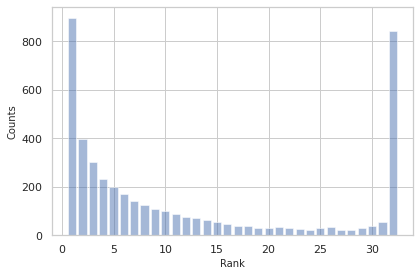

In [60]:
%autoreload
thresh=0.1
nbins=32
rank = reliability.Talagrand(thresh,nbins)
#for tii in [2,3,4,5,6]:
for tii in [7,8,9,10]:
    volcat = aeval.volcat_avg_hash[tii]
    forecast = aeval.cdump_hash[tii]
    dfin = rank.add_data_xra(volcat,forecast)
rank.plotrank()

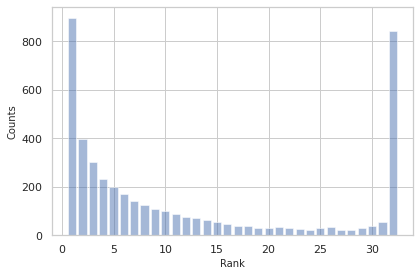

In [61]:
rank.plotrank()